In [1]:
# !pip install pandas_datareader

/bin/sh: 1: pip: not found


In [6]:
import math
from datetime import datetime
import pandas as pd
import pandas_datareader as pdr
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (14,8)
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from keras.models import Sequential
from keras.layers import SimpleRNN, LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import plot_model

tf.set_random_seed(1234)

/home/ubuntu/.local/lib/python3.6/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal
/home/ubuntu/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ubuntu/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ubuntu/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a s

# Data loader

## Data Description

1. features : 시가, 저가, 고가, 종가
1. sequence_length(학습 데이터로 사용되는 기간) : t-19 ~ t-0(20거래일)
2. 각 observation간의 편차가 크면 학습에 방해가 될 수 있기 때문에 regularization을 수행
3. train, valid, test 데이터셋은 각각 70:20:10의 비율로 분할

In [7]:
def get_download_stock(market_type=None):
    stock_type = {'kospi': 'stockMkt', 'kosdaq': 'kosdaqMkt'}
    market_type = stock_type[market_type]
    download_link = 'http://kind.krx.co.kr/corpgeneral/corpList.do?method=download'
    download_link = download_link + '&marketType=' + market_type
    df = pd.read_html(download_link, header=0)[0]
    return df

def get_download_kospi():
    df = get_download_stock('kospi')
    df.종목코드 = df.종목코드.map('{:06d}.KS'.format) # 6자리 코드로 맞춰주기
    return df

def get_download_kosdaq():
    df = get_download_stock('kosdaq')
    df.종목코드 = df.종목코드.map('{:06d}.KQ'.format) # 6자리 코드로 맞춰주기
    return df

def get_code():
    
    code_dic = {}

    # 코스피, 코스닥 종목코드 각각 다운로드
    kospi_df = get_download_kospi()
    kosdaq_df = get_download_kosdaq()

    # 데이터프레임 합치기
    code_df = pd.concat([kospi_df, kosdaq_df])

    # 회사명과 종목코드만 추출
    code_df = code_df[['회사명', '종목코드']]
    
    for name, code in code_df.to_numpy():
        code_dic[name] = code
    
    return code_dic

In [8]:
code_dic = get_code()

In [9]:
# get_data_yahoo API를 통해서 yahho finance의 주식 종목 데이터를 가져온다.
start_date = datetime(2015, 1, 1)
end_date = datetime(2020, 6, 25)

df_m = pdr.get_data_yahoo('^KS11').drop(columns=['Volume', 'Adj Close'])[start_date : end_date]
df_i = pdr.get_data_yahoo(code_dic['삼성전자']).drop(columns=['Volume', 'Adj Close'])[start_date : end_date]

In [10]:
df_m.isnull().sum()

High     0
Low      0
Open     0
Close    0
dtype: int64

In [11]:
df_i.isnull().sum()

High     0
Low      0
Open     0
Close    0
dtype: int64

In [12]:
df_i.describe()

High           Low          Open         Close
count   1220.000000   1220.000000   1220.000000   1220.000000
mean   41736.196721  40893.450820  41308.336066  41323.590164
std    10545.967187  10319.969602  10454.960675  10430.333857
min    21480.000000  20660.000000  21360.000000  21340.000000
25%    32150.000000  31380.000000  31655.000000  31795.000000
50%    45275.000000  44325.000000  44800.000000  44800.000000
75%    49442.500000  48512.500000  49000.000000  49000.000000
max    62800.000000  61700.000000  62000.000000  62400.000000

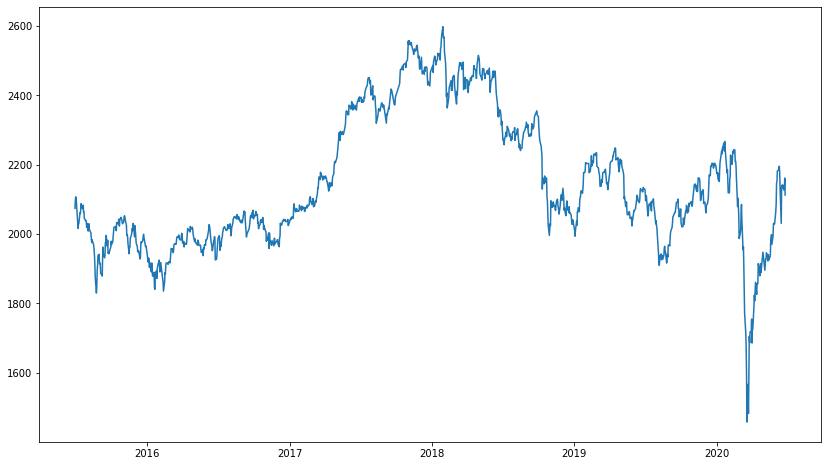

In [13]:
plt.plot(df_m['Close'])
plt.show()

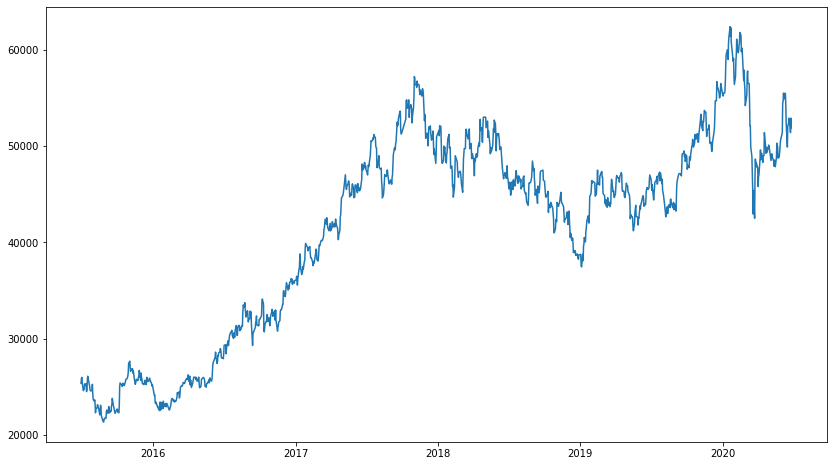

In [14]:
plt.plot(df_i['Close'])
plt.show()

# Basic Process

## Preprocessing

In [15]:
# using custom min_max_scaling
def min_max_scaling(x):
    x_np = np.asarray(x)
    return (x_np - x_np.min()) / (x_np.max() - x_np.min() + 1e-7) # 1e-7은 0으로 나누는 오류 예방차원

def reverse_min_max_scaling(org_x, x):
    org_x_np = np.asarray(org_x)
    x_np = np.asarray(x)
    return (x_np * (org_x_np.max() - org_x_np.min() + 1e-7)) + org_x_np.min()

In [16]:
def preprocess(df, seq_length):
    df_mat = df.to_numpy()
    # using min_max_scaling from Scikit-learn packages
#     scaler = MinMaxScaler()
#     data = scaler.fit_transform(df_mat)

#     print(data)
#     print(f'Min value : {data.min()}')
#     print(f'Max value : {data.max()}')

    data = min_max_scaling(df_mat)
    
    dataX = []
    dataY= []

    for i in range(0, len(data) - seq_length):
        _x = data[i:i + seq_length]
        _y = data[:, -1][i + seq_length]
        dataX.append(_x)
        dataY.append(_y)
        
    print(data)
    
    return dataX, dataY

In [17]:
seq_length = 20
dataX, dataY = preprocess(df_i, seq_length)

[[0.11960133 0.11058377 0.11532985 0.11153299]
 [0.12766967 0.10726151 0.11153299 0.12434741]
 [0.12861889 0.11960133 0.12007594 0.12624585]
 ...
 [0.76269578 0.72235406 0.75557665 0.72947318]
 [0.78879924 0.73421927 0.7413384  0.76506882]
 [0.76744186 0.7413384  0.74608448 0.7413384 ]]


## Split data

In [18]:
train_size = int(len(dataY) * 0.7)
valid_size = int(len(dataY) * 0.2)
test_size = len(dataY) - train_size - valid_size

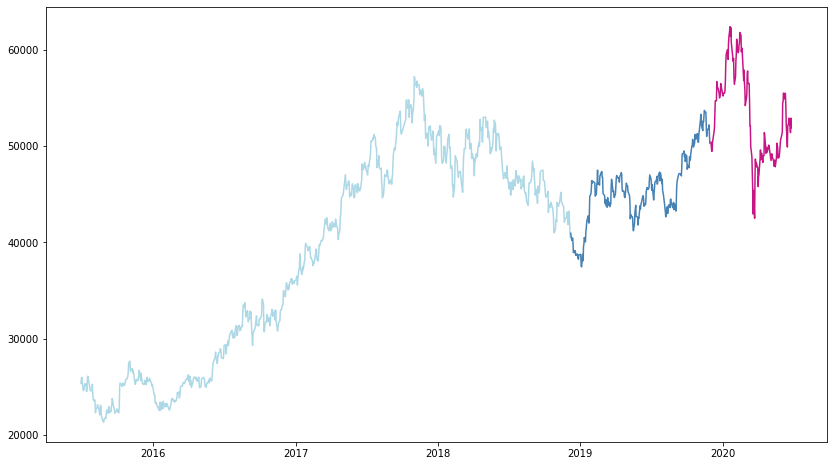

In [19]:
plt.plot(df_i['Close'][:train_size], 'lightblue')
plt.plot(df_i['Close'][train_size : train_size+valid_size], 'steelblue')
plt.plot(df_i['Close'][train_size+valid_size:], 'mediumvioletred')
plt.show()

In [20]:
trainX = np.array(dataX[0:train_size])
trainY = np.array(dataY[0:train_size])

validX = np.array(dataX[train_size:train_size+valid_size])
validY = np.array(dataY[train_size:train_size+valid_size])

testX = np.array(dataX[train_size+valid_size:])
testY = np.array(dataY[train_size+valid_size:])

In [21]:
print(f'trainX shape : {trainX.shape}')
print(f'trainY shape : {trainY.shape}')

print(f'validX shape : {validX.shape}')
print(f'validY shape : {validY.shape}')

print(f'testX shape : {testX.shape}')
print(f'testY shape : {testY.shape}')

trainX shape : (840, 20, 4)
trainY shape : (840,)
validX shape : (240, 20, 4)
validY shape : (240,)
testX shape : (120, 20, 4)
testY shape : (120,)


## Model Structuring & training

In [22]:
model = Sequential()
model.add(LSTM(16, activation='relu', input_shape=(20, 4)))
model.add(Dense(1))

In [23]:
model.compile(optimizer='adam', loss='mse')

es = EarlyStopping(monitor='val_loss', patience=15)

history = model.fit(trainX, trainY, 
                    validation_data=(validX, validY),
                    epochs=100, 
                    batch_size=15,
                    callbacks=[es],
                    verbose=0)

## loss function

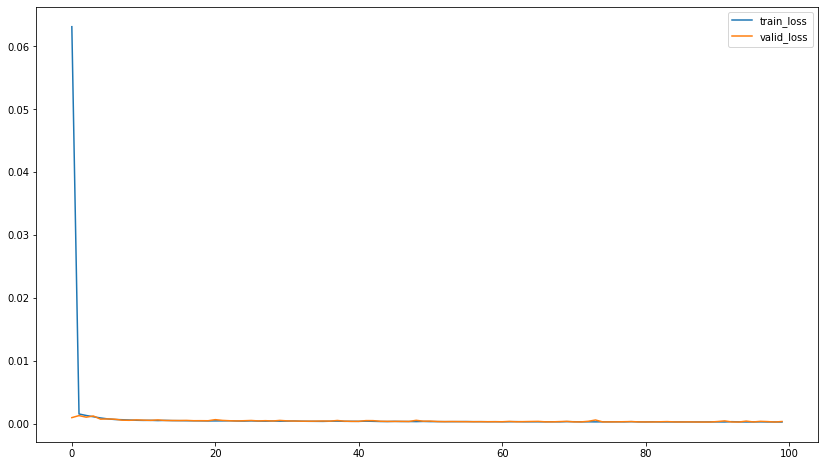

In [24]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train_loss', 'valid_loss'])
plt.show()

In [25]:
trainPredict = model.predict(trainX)
validPredict = model.predict(validX)
testPredict = model.predict(testX)

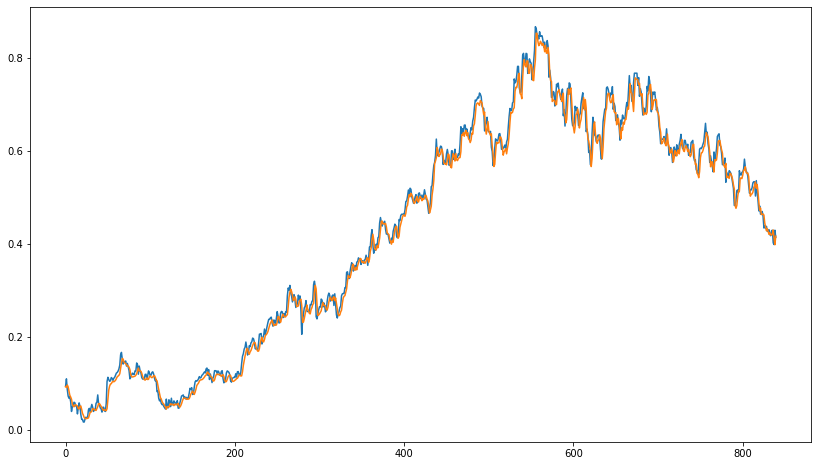

In [26]:
plt.plot(trainY)
plt.plot(trainPredict)
plt.show()

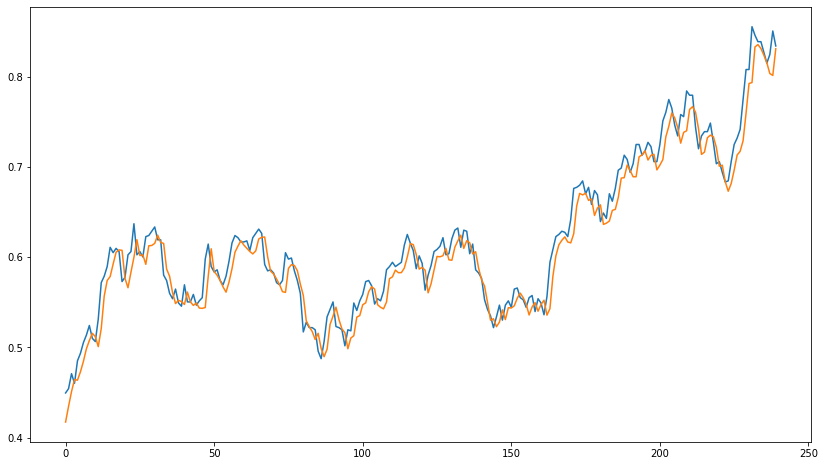

In [27]:
plt.plot(validY)
plt.plot(validPredict)
plt.show()

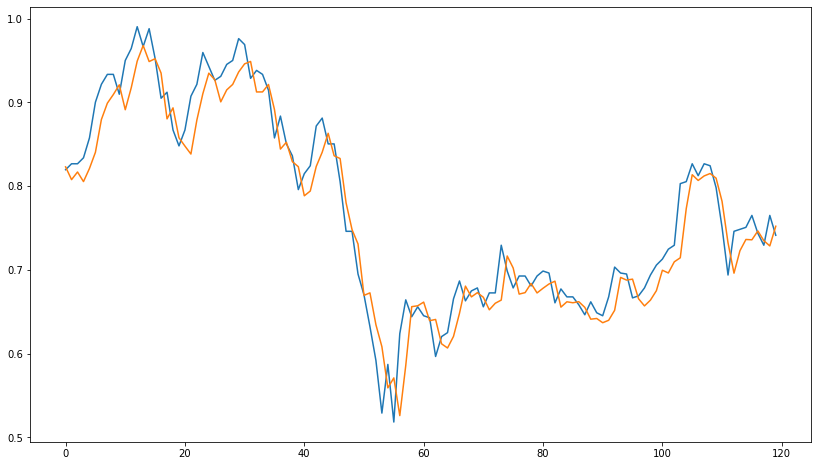

In [28]:
plt.plot(testY)
plt.plot(testPredict)
plt.show()

In [30]:
math.sqrt(np.mean((testPredict-testY)**2))

0.16157756831696068

## Predict price

In [31]:
true_price = reverse_min_max_scaling(df_i, testY)
pred_price = reverse_min_max_scaling(df_i, testPredict)

print(f'Tomorrow price prediction : {pred_price[-1]}')
print(f'Tomorrow price direction : {pred_price[-1] - true_price[-1]}')

Tomorrow price prediction : [52355.33]
Tomorrow price direction : [455.32812]


# Main Test

## Custom definition

In [34]:
def visualization(history, trainPredict, validPredict, testPredict):

    fig, ax = plt.subplots(4, 1, figsize=(15, 35))

    ax[0].plot(history.history['loss'])

    ax[1].plot(trainY)
    ax[1].plot(trainPredict)
    ax[1].set_title('Train')
    ax[1].legend(['Real', 'Predict'])

    ax[2].plot(validY)
    ax[2].plot(validPredict)
    ax[2].set_title('Valid')
    ax[2].legend(['Real', 'Predict'])
        

    ax[3].plot(testY)
    ax[3].plot(testPredict)
    ax[3].set_title('Test')
    ax[3].legend(['Real', 'Predict'])
    
    plt.show()

In [35]:
def preprocessing(df, seq_length):
    
    # using custom min_max_scaling
    def min_max_scaling(x):
        x_np = np.asarray(x)
        return (x_np - x_np.min()) / (x_np.max() - x_np.min() + 1e-7) # 1e-7은 0으로 나누는 오류 예방차원

    def reverse_min_max_scaling(org_x, x):
        org_x_np = np.asarray(org_x)
        x_np = np.asarray(x)
        return (x_np * (org_x_np.max() - org_x_np.min() + 1e-7)) + org_x_np.min()
    
    
    ## preprocessing ##
    df_mat = df.to_numpy()
    data = min_max_scaling(df_mat)

    dataX = []
    dataY= []

    for i in range(0, len(data) - seq_length):
        _x = data[i:i + seq_length]
        _y = data[:, -1][i + seq_length]
        dataX.append(_x)
        dataY.append(_y)
        
        
    ## split train, valid, test ##  
    train_size = int(len(dataY) * 0.7)
    valid_size = int(len(dataY) * 0.2)
    test_size = len(dataY) - train_size - valid_size
    
    trainX = np.array(dataX[0:train_size])
    trainY = np.array(dataY[0:train_size])

    validX = np.array(dataX[train_size:train_size+valid_size])
    validY = np.array(dataY[train_size:train_size+valid_size])

    testX = np.array(dataX[train_size+valid_size:])
    testY = np.array(dataY[train_size+valid_size:])
    
    print(f'trainX shape : {trainX.shape}')
    print(f'trainY shape : {trainY.shape}')

    print(f'validX shape : {validX.shape}')
    print(f'validY shape : {validY.shape}')

    print(f'testX shape : {testX.shape}')
    print(f'testY shape : {testY.shape}')
    
    return trainX, trainY, validX, validY, testX, testY

In [47]:
def model_1(trainX, trainY, validX, validY, testX, testY, L_node, activation, optimizer, batch_size, epochs):
    
    ## model structure ##
    model = Sequential()
    model.add(LSTM(L_node, activation=activation, input_shape=(20, 4)))
    model.add(Dense(1))
    
    ### training ###
    model.compile(optimizer=optimizer, loss='mse')
    es = EarlyStopping(monitor='val_loss', patience=15)

    history = model.fit(trainX, trainY, 
                        validation_data=(validX, validY),
                        epochs=epochs, 
                        batch_size=batch_size,
                        callbacks=[es],
                        verbose=0)
    
    trainPredict = model.predict(trainX)
    validPredict = model.predict(validX)
    testPredict = model.predict(testX)
    
    
    ## visualization
    fig, ax = plt.subplots(4, 1, figsize=(15, 35))

    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[0].legend(['train_loss', 'valid_loss'])

    ax[1].plot(trainY)
    ax[1].plot(trainPredict)
    ax[1].set_title('Train')
    ax[1].legend(['Real', 'Predict'])

    ax[2].plot(validY)
    ax[2].plot(validPredict)
    ax[2].set_title('Valid')
    ax[2].legend(['Real', 'Predict'])
        

    ax[3].plot(testY)
    ax[3].plot(testPredict)
    ax[3].set_title('Test')
    ax[3].legend(['Real', 'Predict'])
    
    plt.show()
    print(f"RMSE : {float(np.mean((testPredict-testY)**2))}")
    
    return trainPredict, validPredict, testPredict

In [48]:
def model_2(trainX, trainY, validX, validY, testX, testY, L_node, activation, optimizer, batch_size, D_node, dropout, epochs):
    
    ## model structure ##
    model = Sequential()
    model.add(LSTM(L_node, activation=activation, input_shape=(20, 4)))
    model.add(Dense(D_node))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    
    
    ### training ###
    model.compile(optimizer=optimizer, loss='mse')
    es = EarlyStopping(monitor='val_loss', patience=15)

    history = model.fit(trainX, trainY, 
                        validation_data=(validX, validY),
                        epochs=epochs, 
                        batch_size=batch_size,
                        callbacks=[es],
                        verbose=0)
    
    trainPredict = model.predict(trainX)
    validPredict = model.predict(validX)
    testPredict = model.predict(testX)
    
    
    ## visualization
    fig, ax = plt.subplots(4, 1, figsize=(15, 35))

    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[0].legend(['train_loss', 'valid_loss'])

    ax[1].plot(trainY)
    ax[1].plot(trainPredict)
    ax[1].set_title('Train')
    ax[1].legend(['Real', 'Predict'])

    ax[2].plot(validY)
    ax[2].plot(validPredict)
    ax[2].set_title('Valid')
    ax[2].legend(['Real', 'Predict'])
        

    ax[3].plot(testY)
    ax[3].plot(testPredict)
    ax[3].set_title('Test')
    ax[3].legend(['Real', 'Predict'])
    
        
    plt.show()
    print(f"RMSE : {float(np.mean((testPredict-testY)**2))}")
    
    return trainPredict, validPredict, testPredict

## Model Summary

In [38]:
model_tmp = Sequential()
model_tmp.add(LSTM(16, input_shape=(20, 4)))
model_tmp.add(Dense(1))

model_tmp.summary()
# plot_model(model_tmp, show_shapes=True)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 16)                1344      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 1,361
Trainable params: 1,361
Non-trainable params: 0
_________________________________________________________________


In [39]:
model_tmp = Sequential()
model_tmp.add(LSTM(128, input_shape=(20, 4)))
model_tmp.add(Dense(64))
model_tmp.add(Dropout(0.15))
model_tmp.add(Dense(1))

model_tmp.summary()
# plot_model(model_tmp, show_shapes=True)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 128)               68096     
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 76,417
Trainable params: 76,417
Non-trainable params: 0
_________________________________________________________________


## Contents of Test


+ Section 1 - model_1(Simple LSTM)을 통해 t + 1의 종가 예측

    - Test 1 - Optimizer(SGD, RMSProp, Adam, Adadelta, Adagrad, Adamax, Nadam) test
    - Test 2 - batch_size(8, 16, 32, 64) test
    - Test 3 - LSTM node(8, 16, 32) test
    - Test 4 - activation(tanh, relu, sigmoid) test


+ Section 2 - model_2(added fully connected layer)

    - Test 1 - Dense node(8, 16, 32, 64) test


+ Section 3 - Add Market Index(KOSPI Index)


+ Section 4 - Predict 5-days stock movements

## Section 1 - model_1(Simple LSTM)을 통해 t+1의 종가 예측

### Test 1 - *optimizer(SGD, RMSprop, Adam, Adadelta, Adagrad, Adamax, Nadam) test*

- model : model_1(Simple LSTM)
- LSTM node : 16
- activation : 'relu'
- batch_size : 16
- epochs : 100
- early_stopping : yes

In [40]:
trainX, trainY, validX, validY, testX, testY = preprocessing(df_i, 20)

trainX shape : (840, 20, 4)
trainY shape : (840,)
validX shape : (240, 20, 4)
validY shape : (240,)
testX shape : (120, 20, 4)
testY shape : (120,)


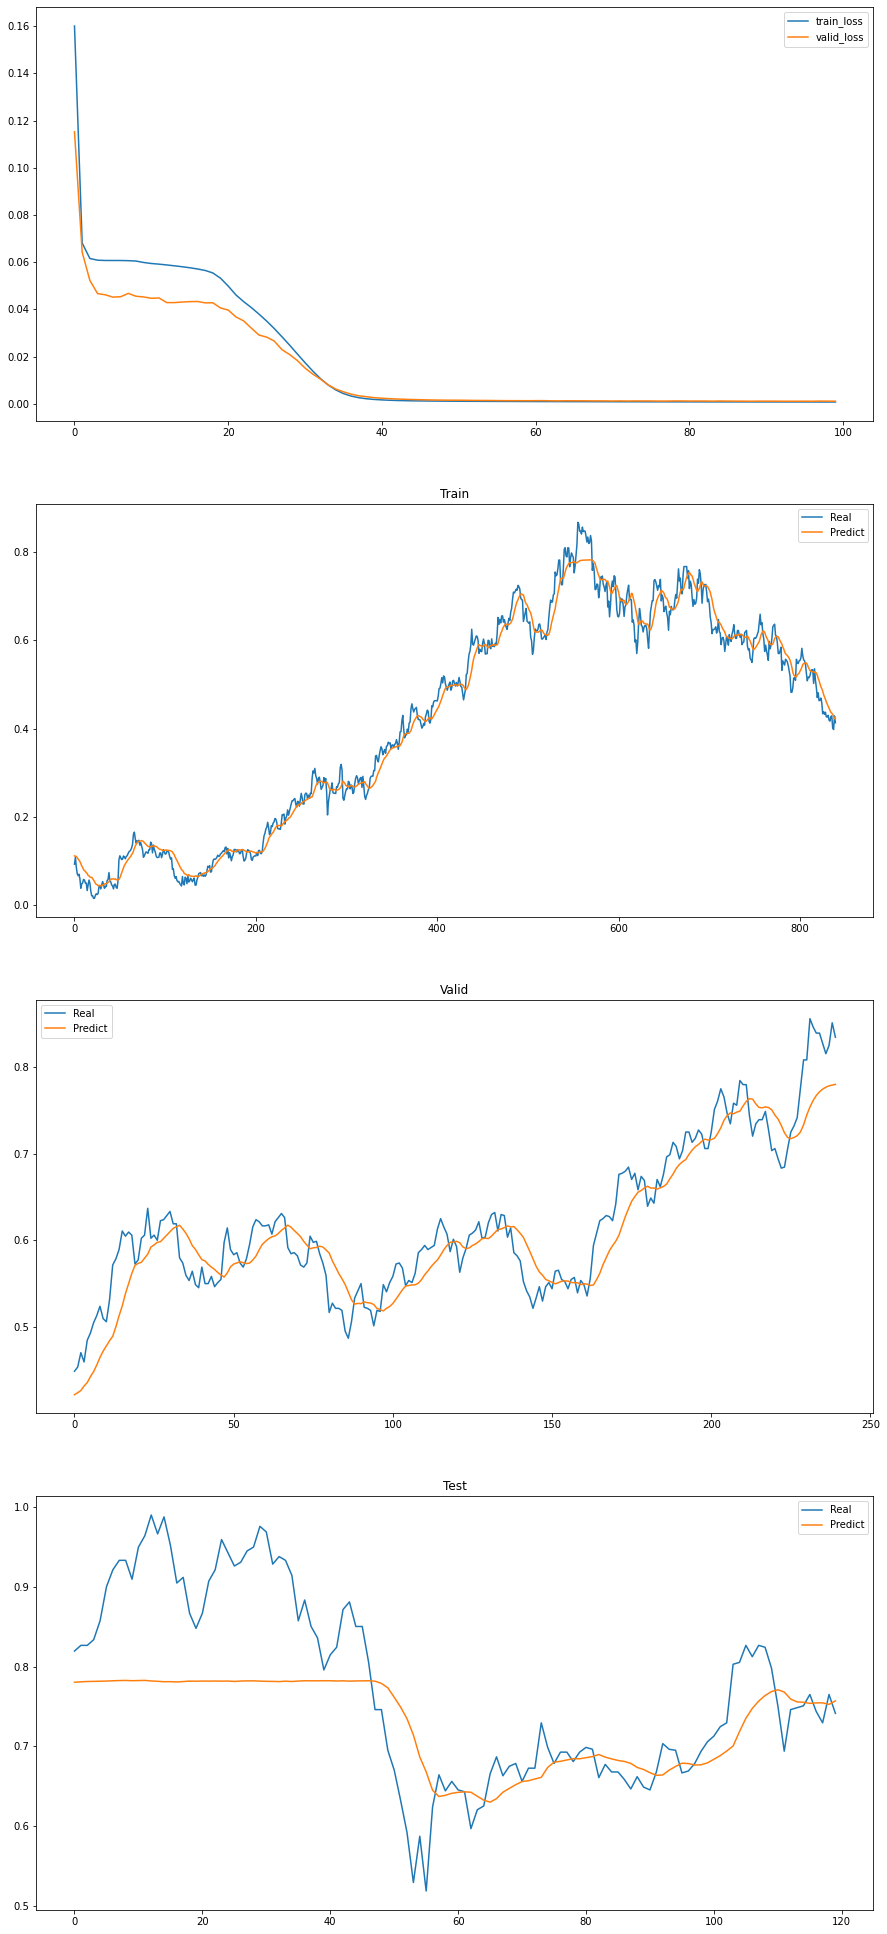

RMSE : 0.01862485845519803


In [49]:
L_node = 16
activation = 'relu'
optimizer = 'sgd'
batch_size = 16
epochs = 100

trainPredict, validPredict, testPredict = model_1(trainX, trainY, validX, validY, testX, testY, 
                                                  L_node, 
                                                  activation, 
                                                  optimizer, 
                                                  batch_size,  
                                                  epochs)

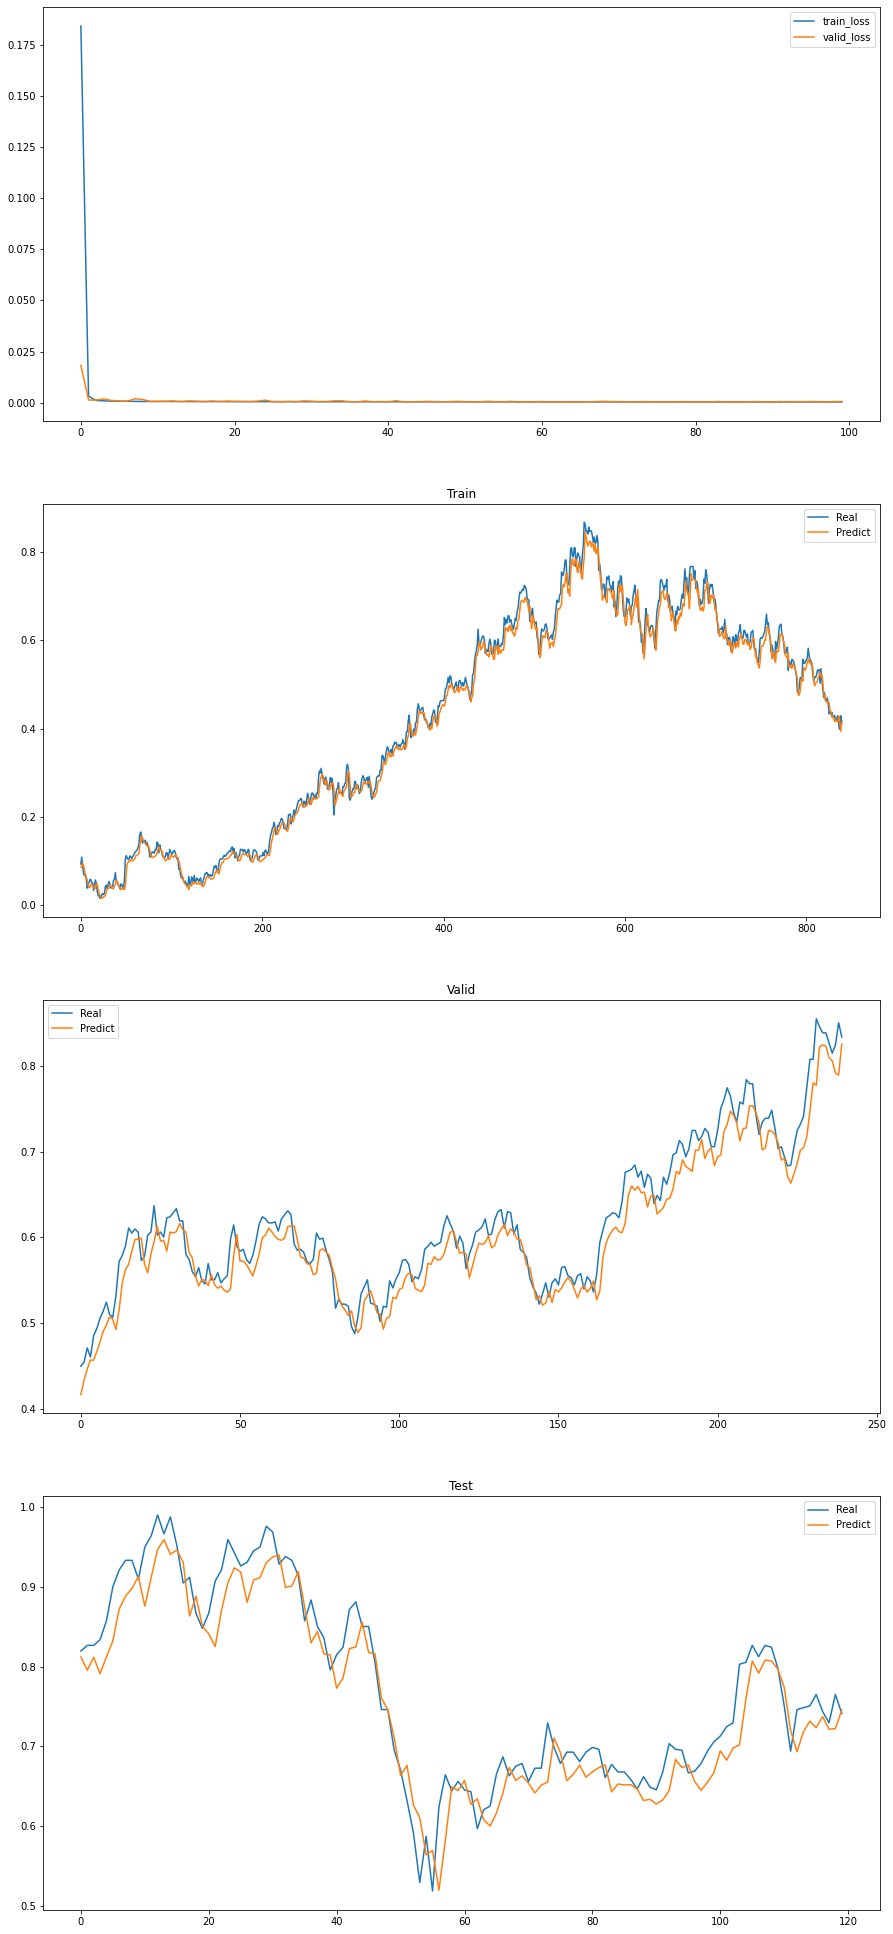

RMSE : 0.02627408047454816


In [50]:
L_node = 16
activation = 'relu'
optimizer = 'rmsprop'
batch_size = 16
epochs = 100

trainPredict, validPredict, testPredict = model_1(trainX, trainY, validX, validY, testX, testY, 
                                                  L_node, 
                                                  activation, 
                                                  optimizer, 
                                                  batch_size,  
                                                  epochs)

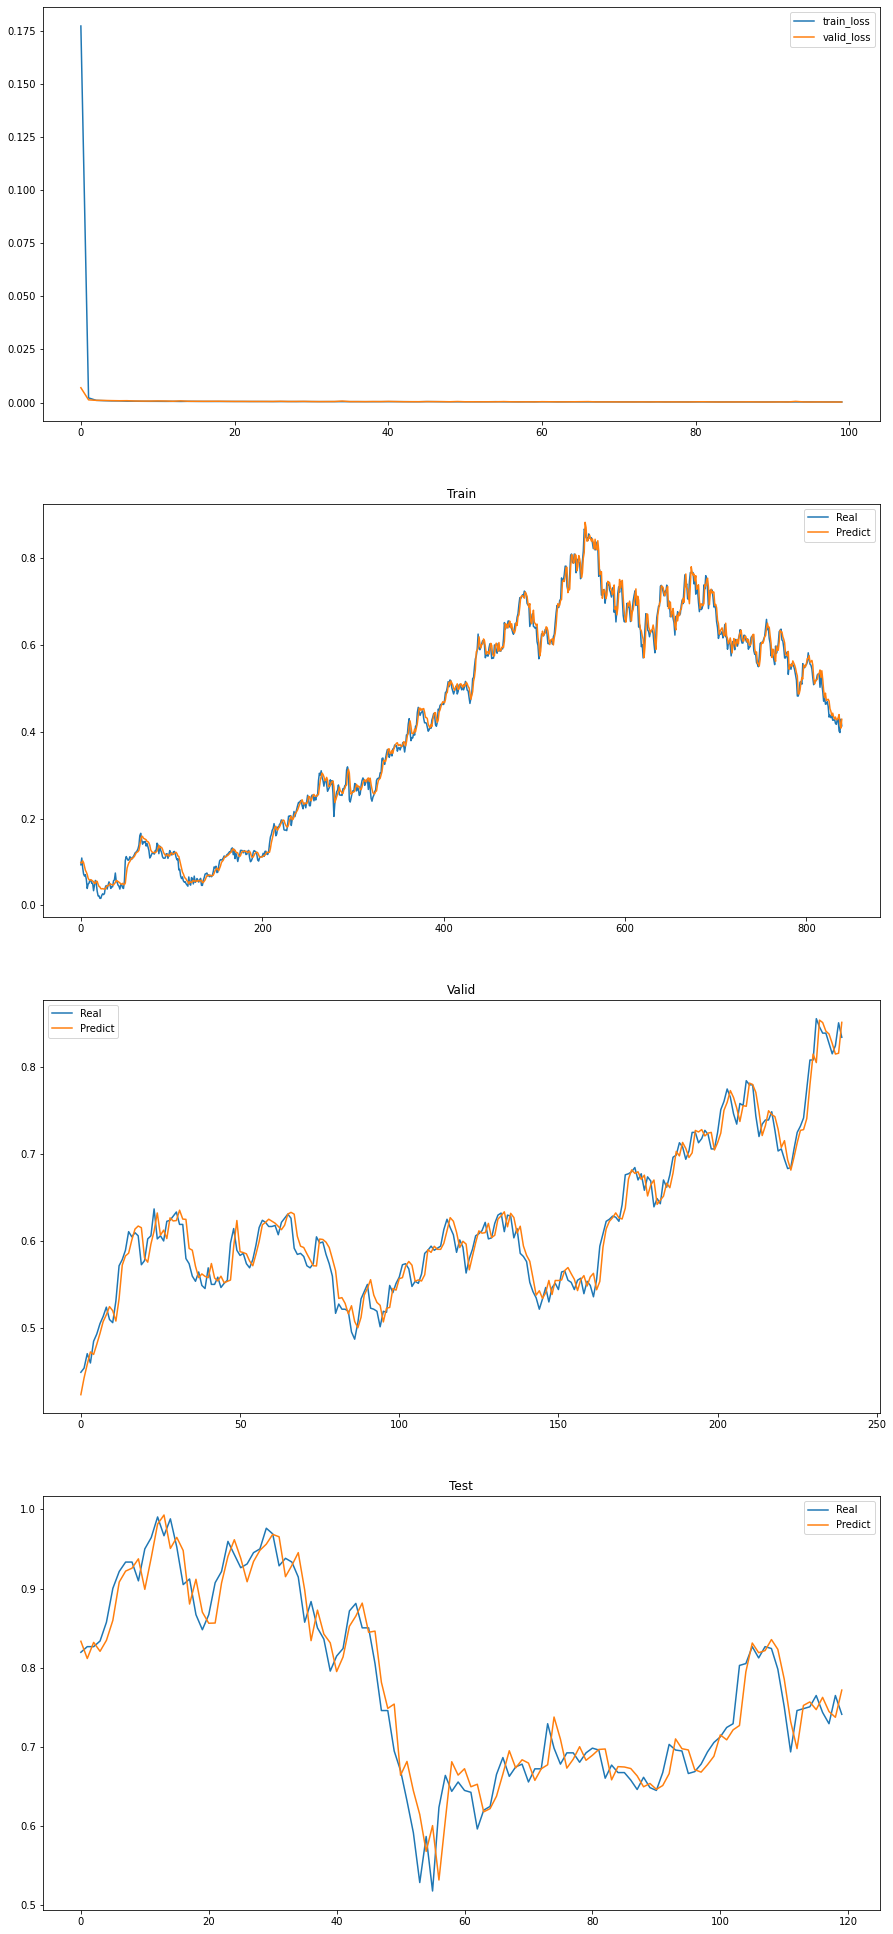

RMSE : 0.026499670568219


In [51]:
L_node = 16
activation = 'relu'
optimizer = 'adam'
batch_size = 16
epochs = 100

trainPredict, validPredict, testPredict = model_1(trainX, trainY, validX, validY, testX, testY, 
                                                  L_node, 
                                                  activation, 
                                                  optimizer, 
                                                  batch_size,  
                                                  epochs)

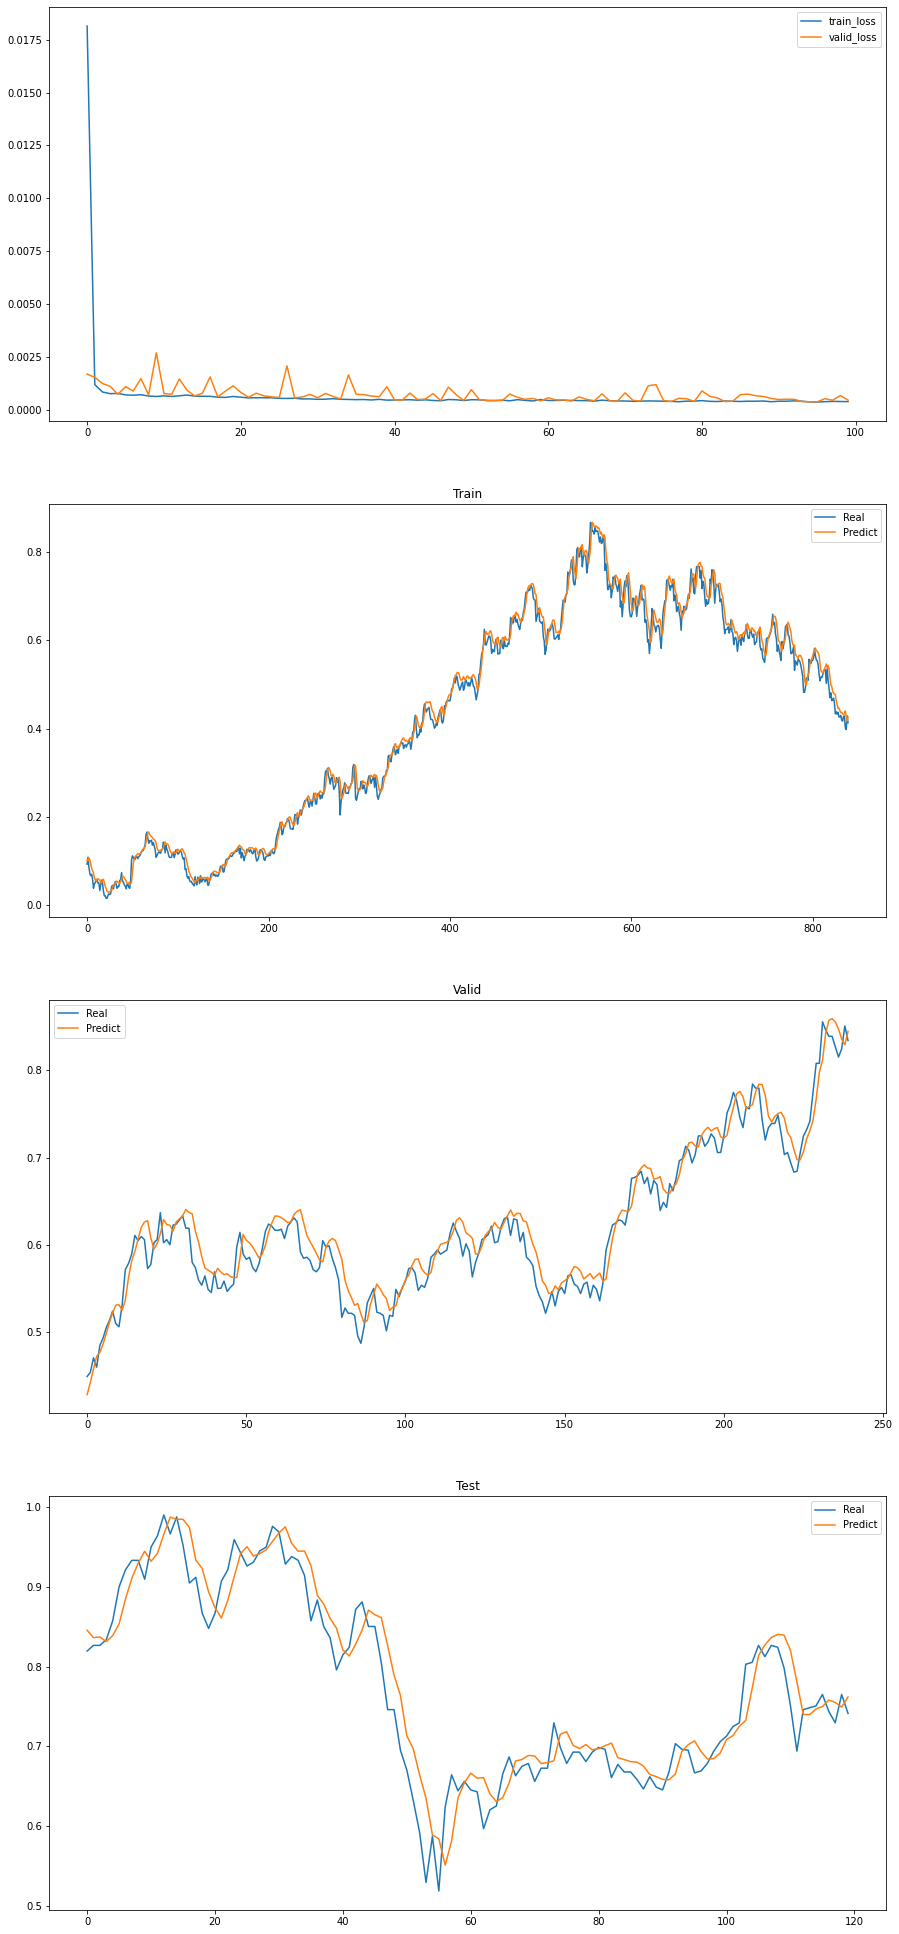

RMSE : 0.02679648218033582


In [52]:
L_node = 16
activation = 'relu'
optimizer = 'adadelta'
batch_size = 16
epochs = 100

trainPredict, validPredict, testPredict = model_1(trainX, trainY, validX, validY, testX, testY, 
                                                  L_node, 
                                                  activation, 
                                                  optimizer, 
                                                  batch_size,  
                                                  epochs)

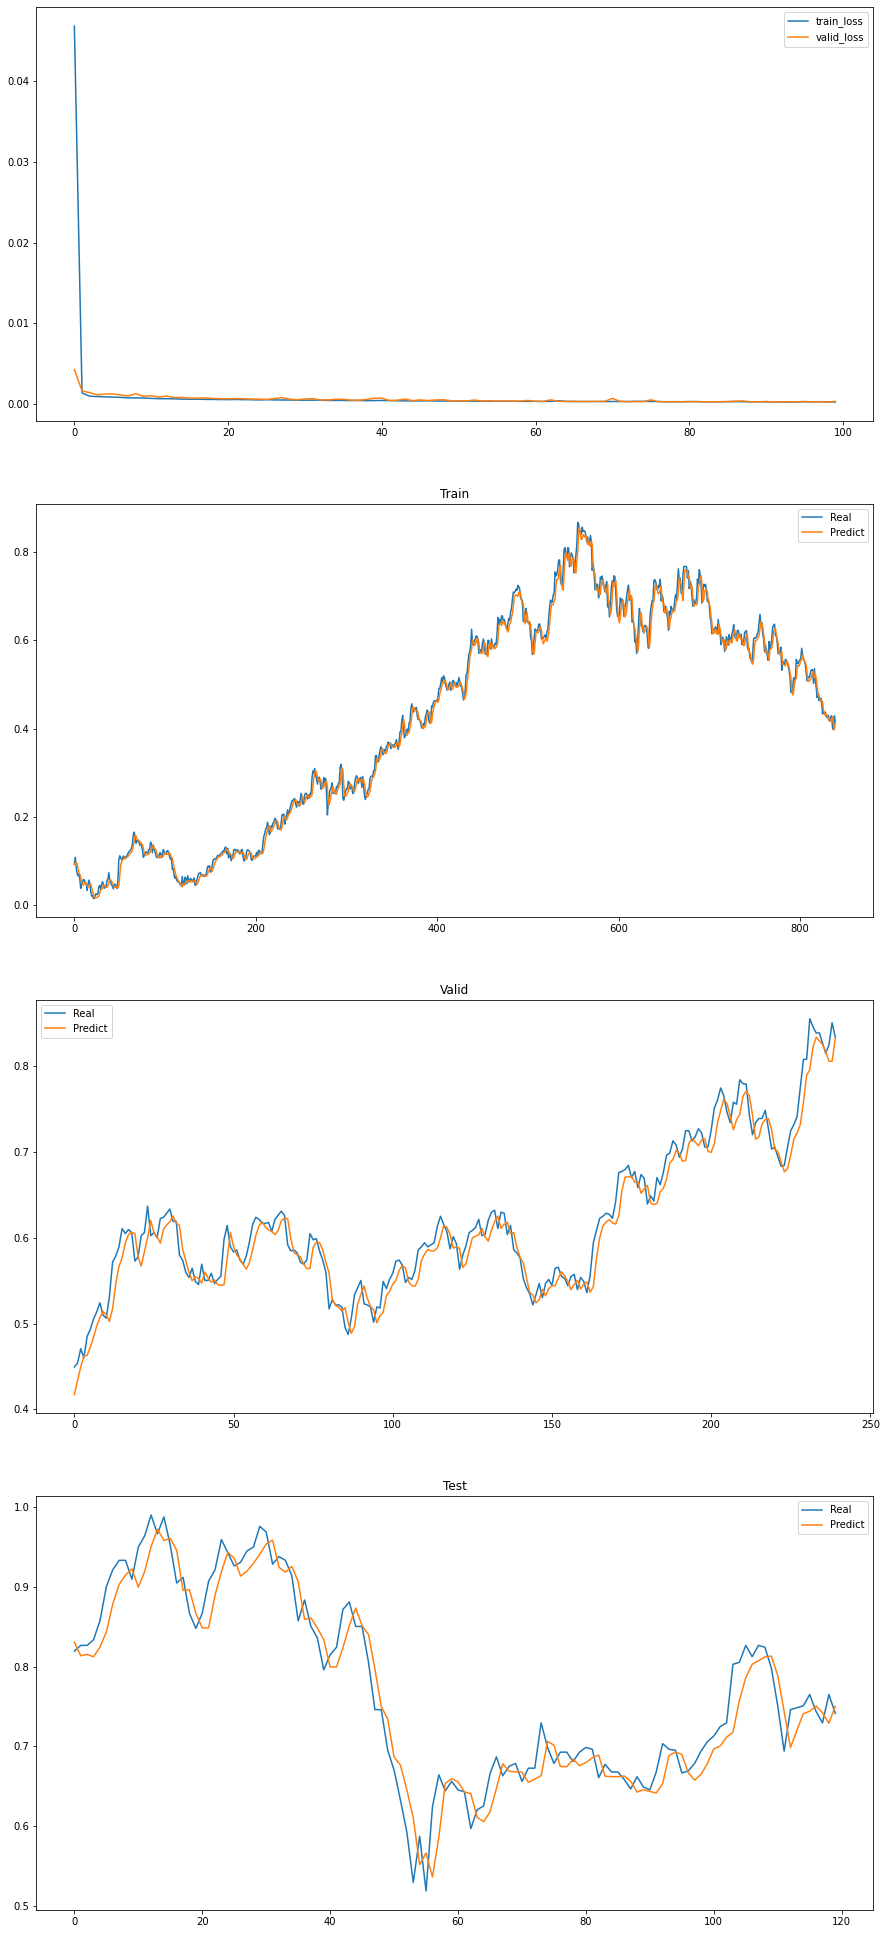

RMSE : 0.02663836401584524


In [53]:
L_node = 16
activation = 'relu'
optimizer = 'adamax'
batch_size = 16
epochs = 100

trainPredict, validPredict, testPredict = model_1(trainX, trainY, validX, validY, testX, testY, 
                                                  L_node, 
                                                  activation, 
                                                  optimizer, 
                                                  batch_size,  
                                                  epochs)

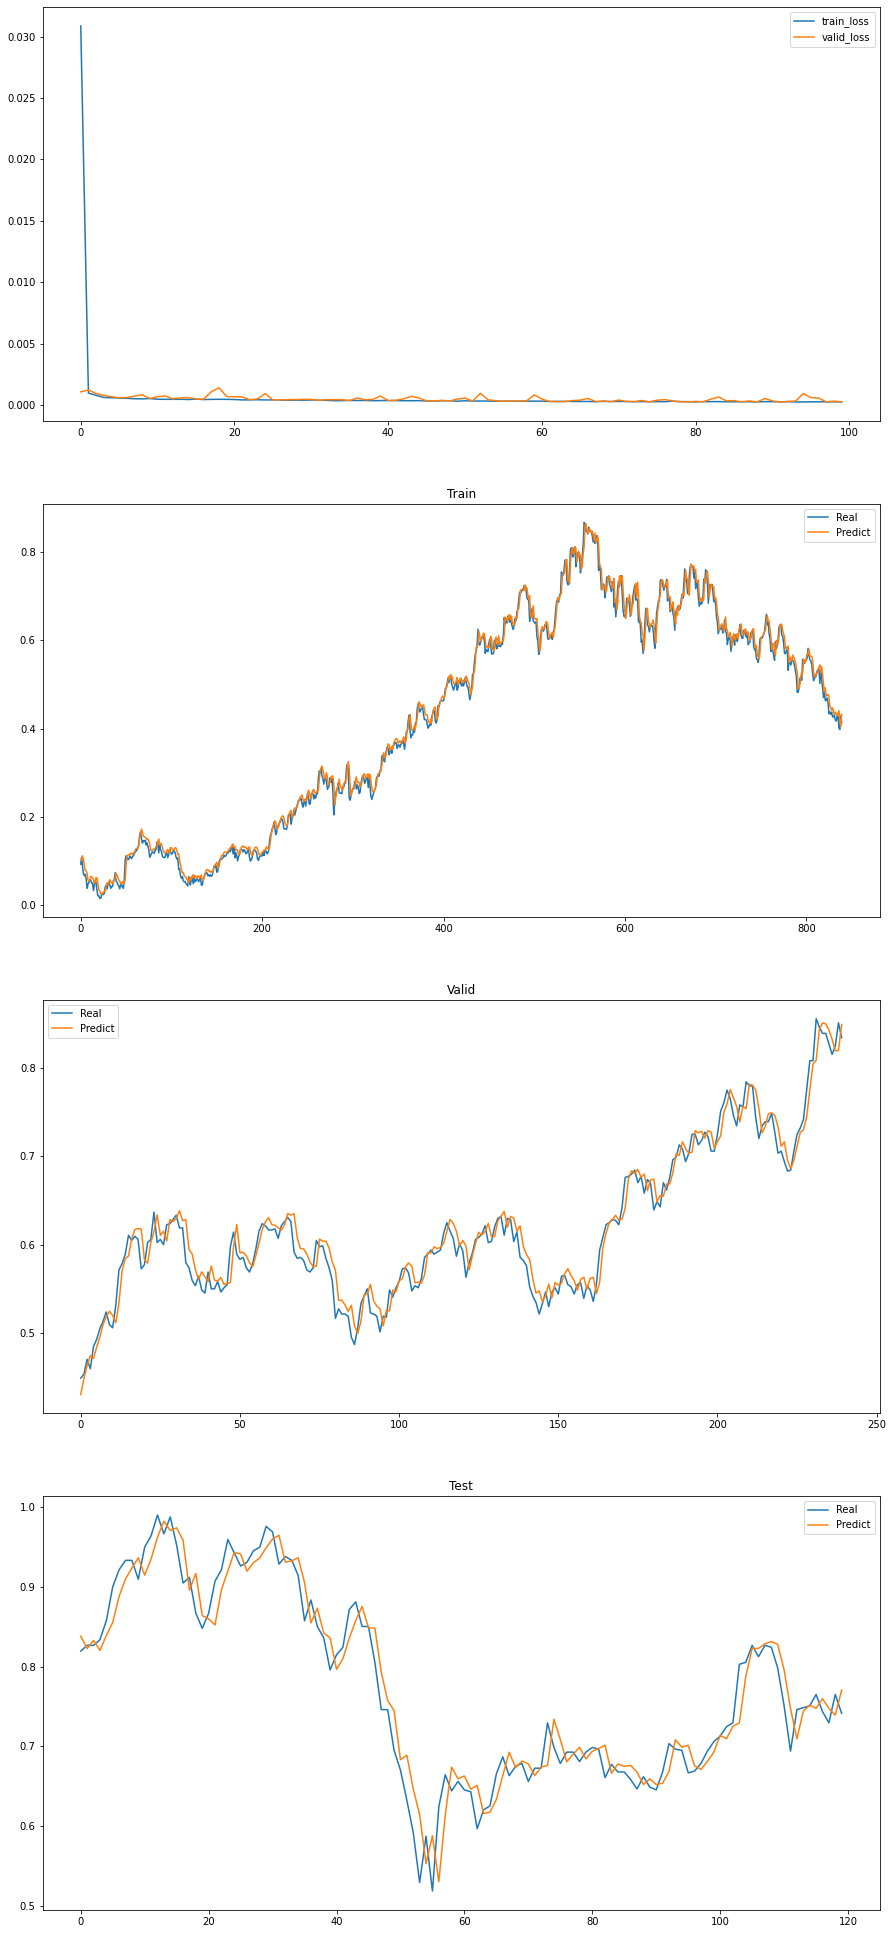

RMSE : 0.02636922646470972


In [54]:
L_node = 16
activation = 'relu'
optimizer = 'nadam'
batch_size = 16
epochs = 100

trainPredict, validPredict, testPredict = model_1(trainX, trainY, validX, validY, testX, testY, 
                                                  L_node, 
                                                  activation, 
                                                  optimizer, 
                                                  batch_size,  
                                                  epochs)

### Test 2 - *batch_size(8, 16, 32, 64) test*

- model : model_1(Simple LSTM)
- LSTM node : 16
- activation : 'relu'
- optimizer : 'adam'
- epochs : 100
- early_stopping : yes

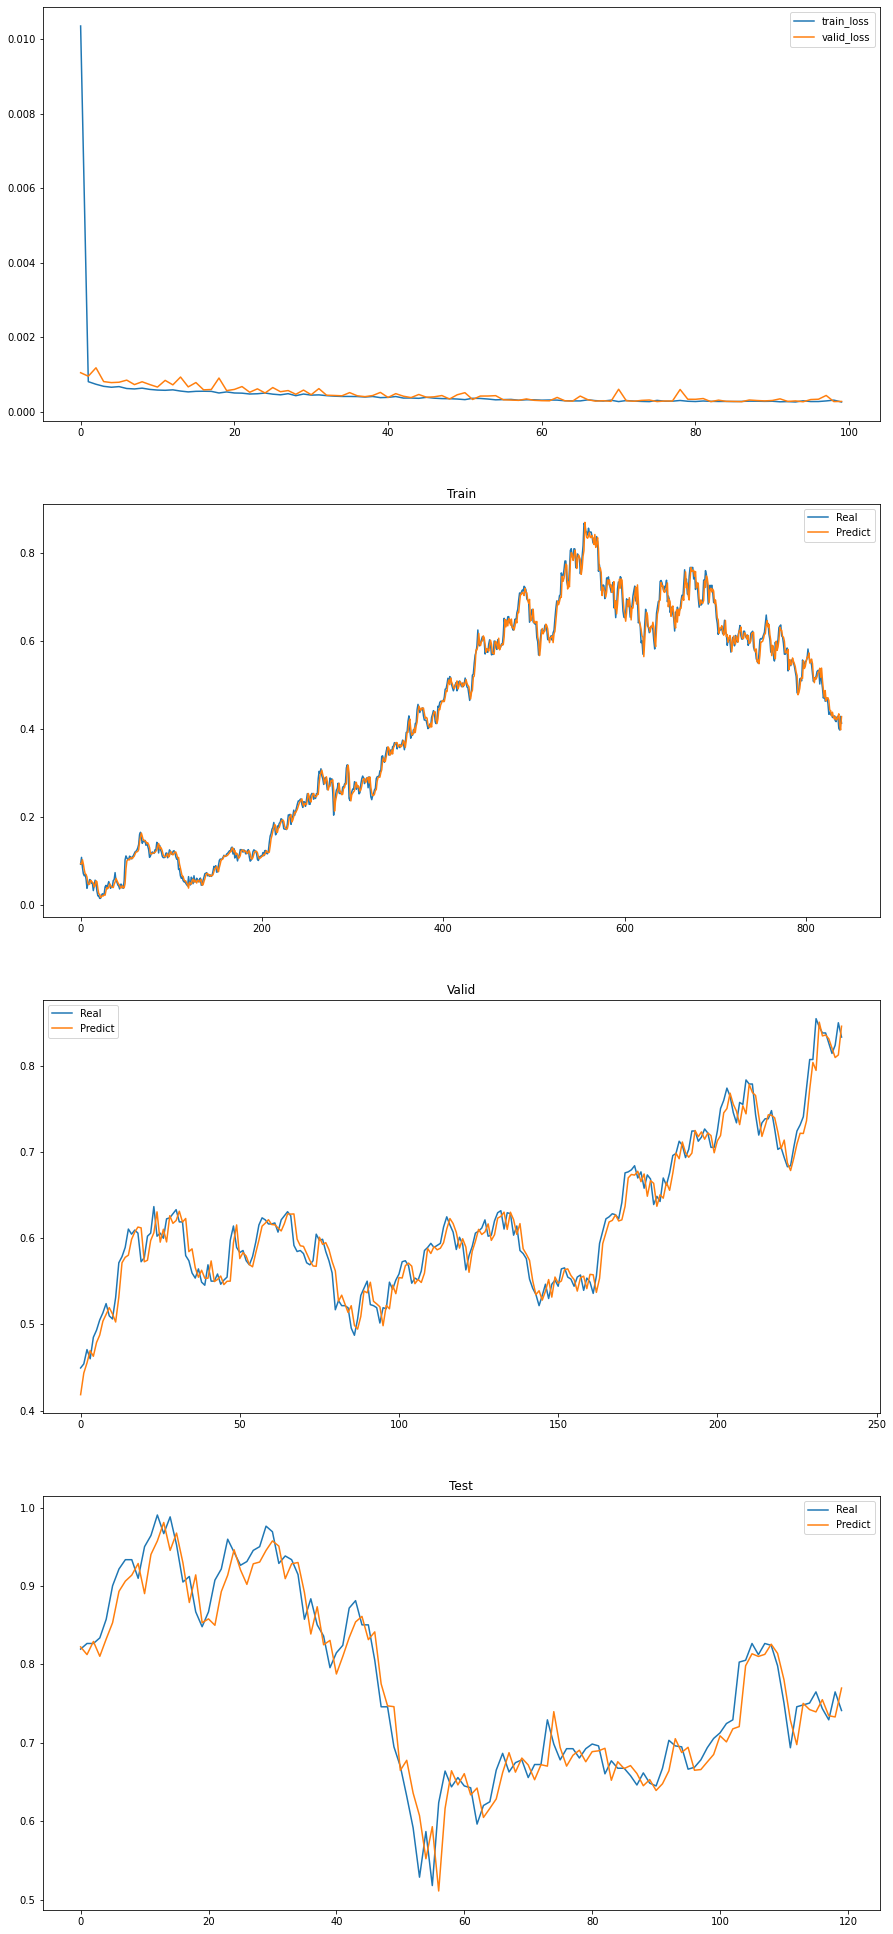

RMSE : 0.02620631464970467


In [55]:
L_node = 16
activation = 'relu'
optimizer = 'adam'
batch_size = 8
epochs = 100

trainPredict, validPredict, testPredict = model_1(trainX, trainY, validX, validY, testX, testY, 
                                                  L_node, 
                                                  activation, 
                                                  optimizer, 
                                                  batch_size,  
                                                  epochs)

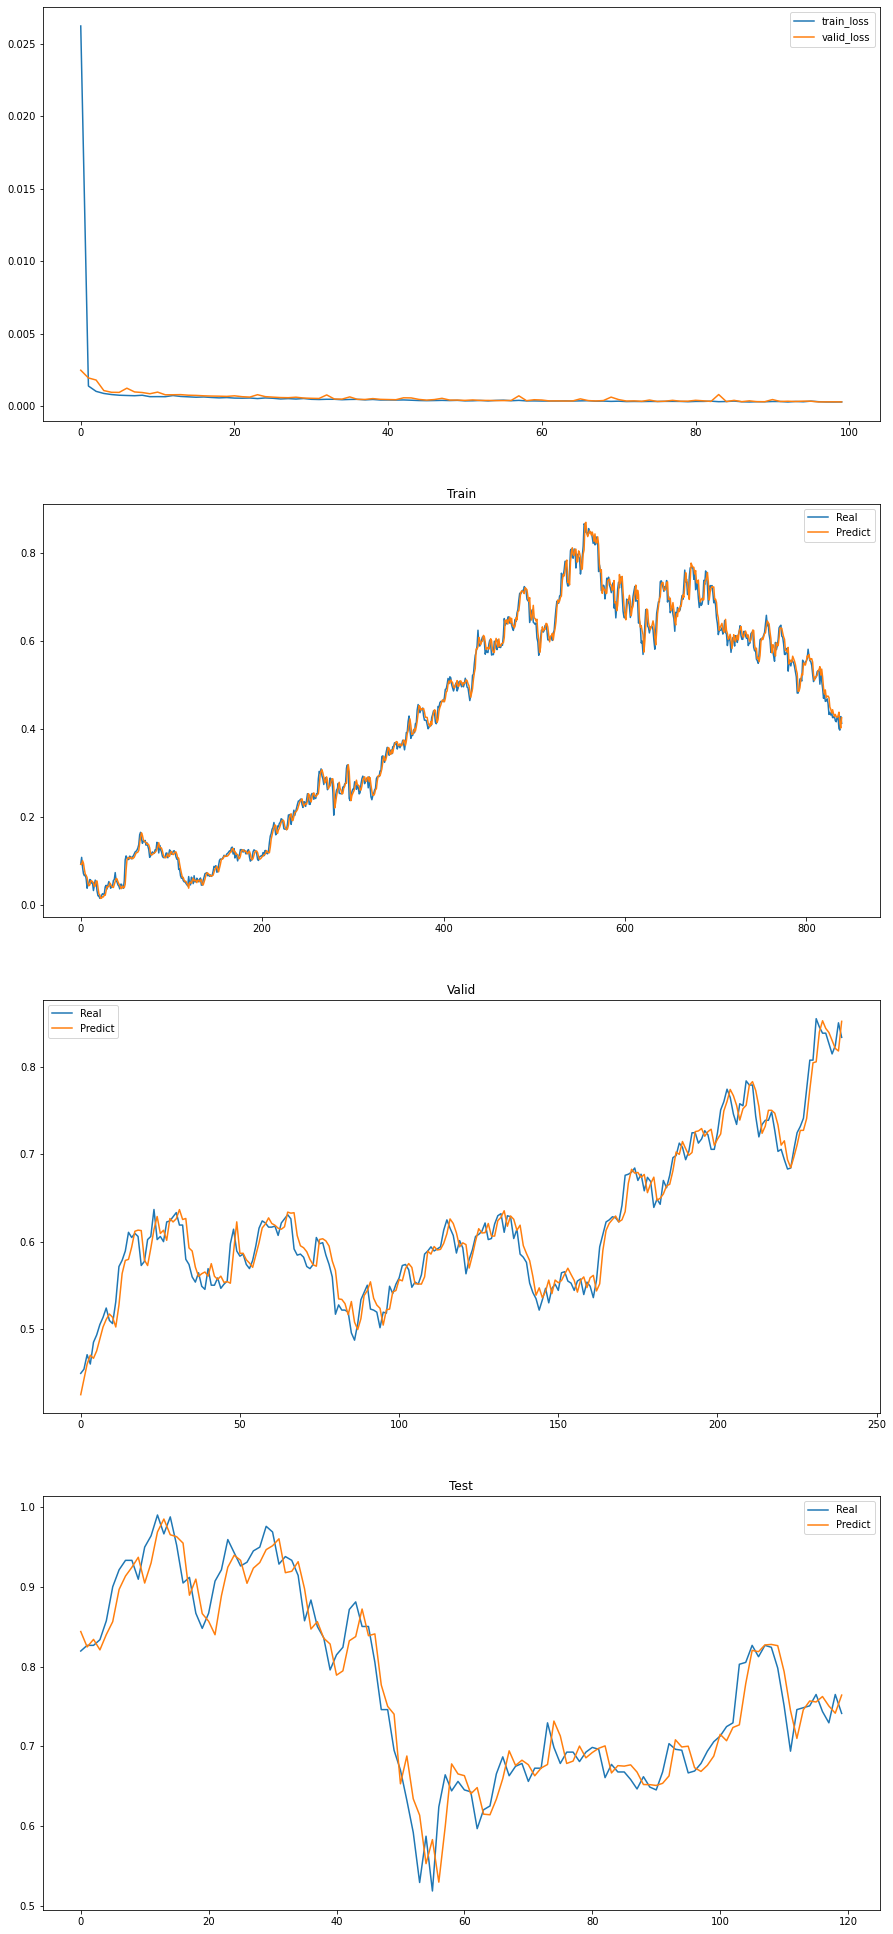

RMSE : 0.026133778438290716


In [56]:
L_node = 16
activation = 'relu'
optimizer = 'adam'
batch_size = 16
epochs = 100

trainPredict, validPredict, testPredict = model_1(trainX, trainY, validX, validY, testX, testY, 
                                                  L_node, 
                                                  activation, 
                                                  optimizer, 
                                                  batch_size,  
                                                  epochs)

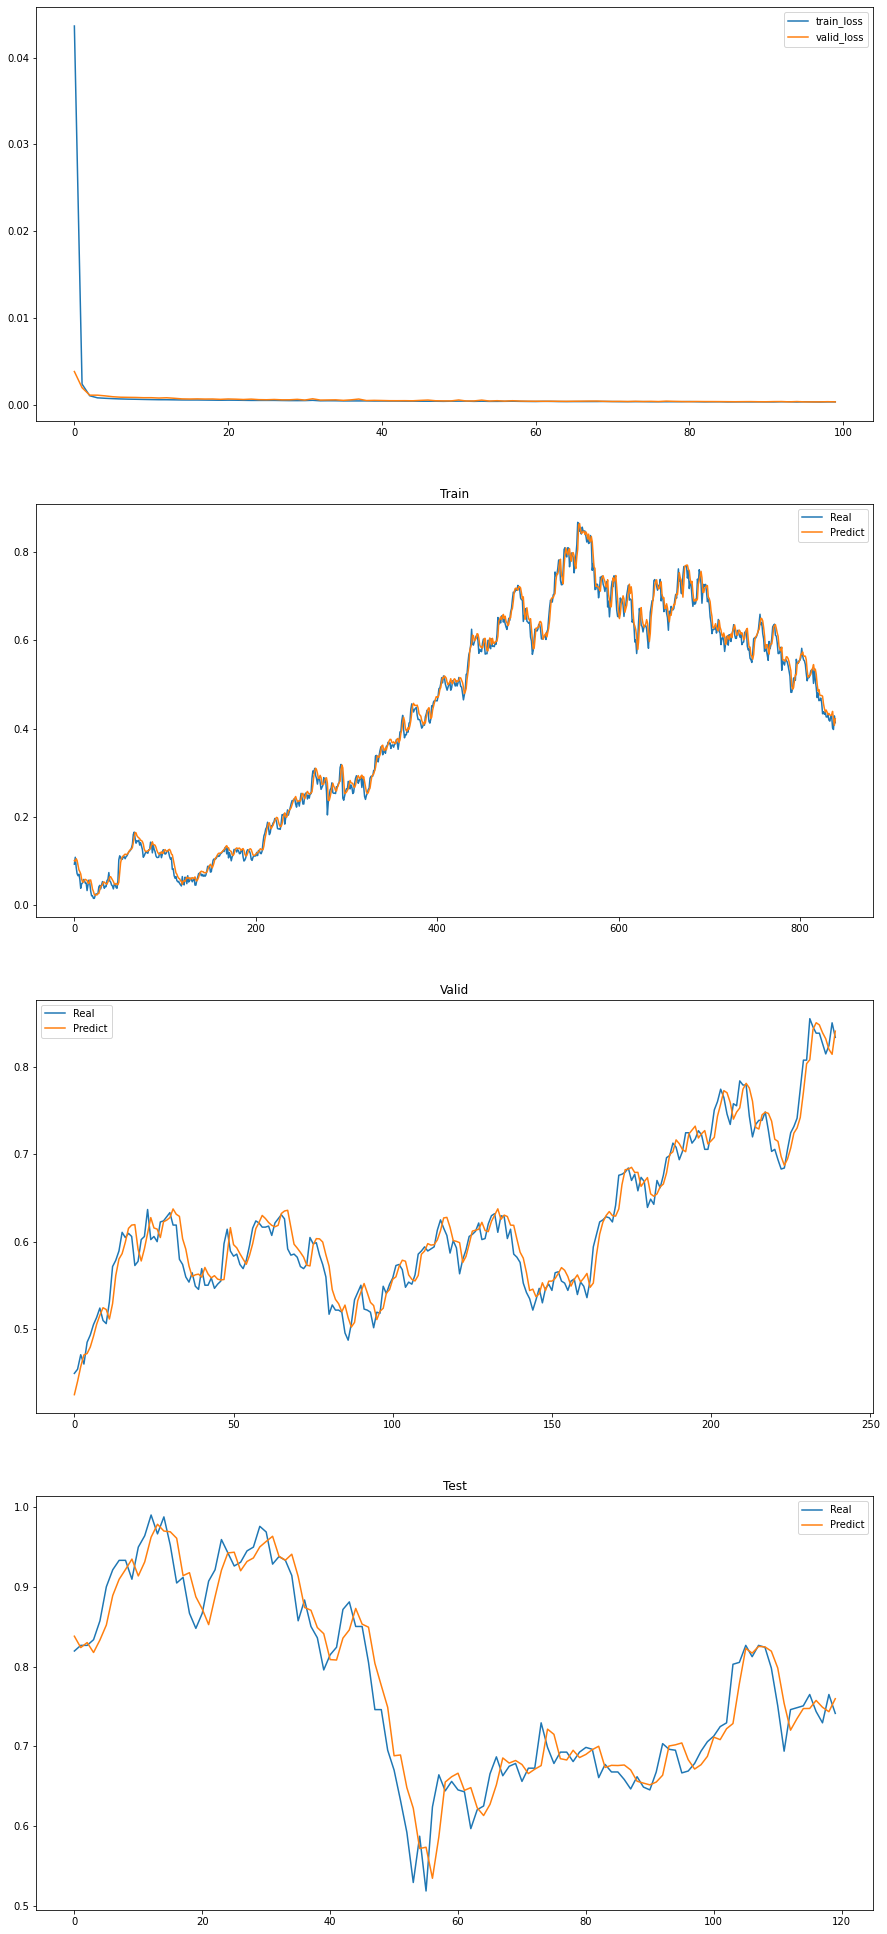

RMSE : 0.02654672781213467


In [57]:
L_node = 16
activation = 'relu'
optimizer = 'adam'
batch_size = 32
epochs = 100

trainPredict, validPredict, testPredict = model_1(trainX, trainY, validX, validY, testX, testY, 
                                                  L_node,
                                                  activation,
                                                  optimizer, 
                                                  batch_size,  
                                                  epochs)

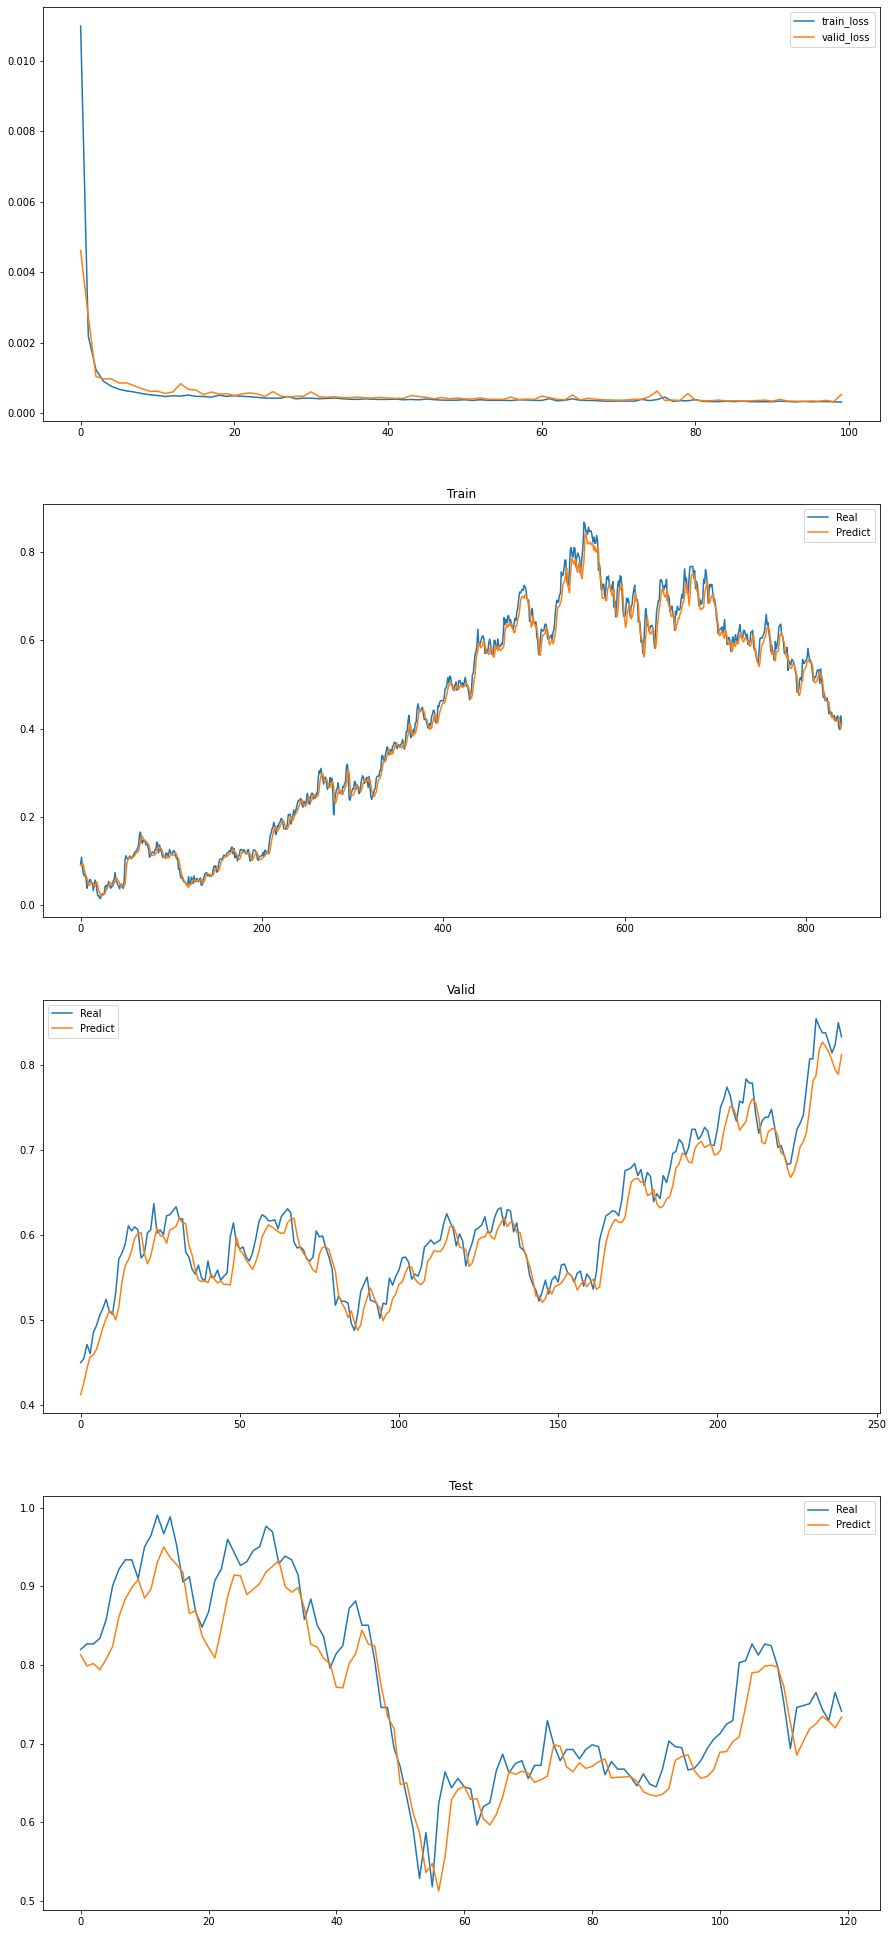

RMSE : 0.025912734895728637


In [58]:
L_node = 16
activation = 'relu'
optimizer = 'adam'
batch_size = 64
epochs = 100

trainPredict, validPredict, testPredict = model_1(trainX, trainY, validX, validY, testX, testY, 
                                                  L_node, 
                                                  activation, 
                                                  optimizer, 
                                                  batch_size,  
                                                  epochs)

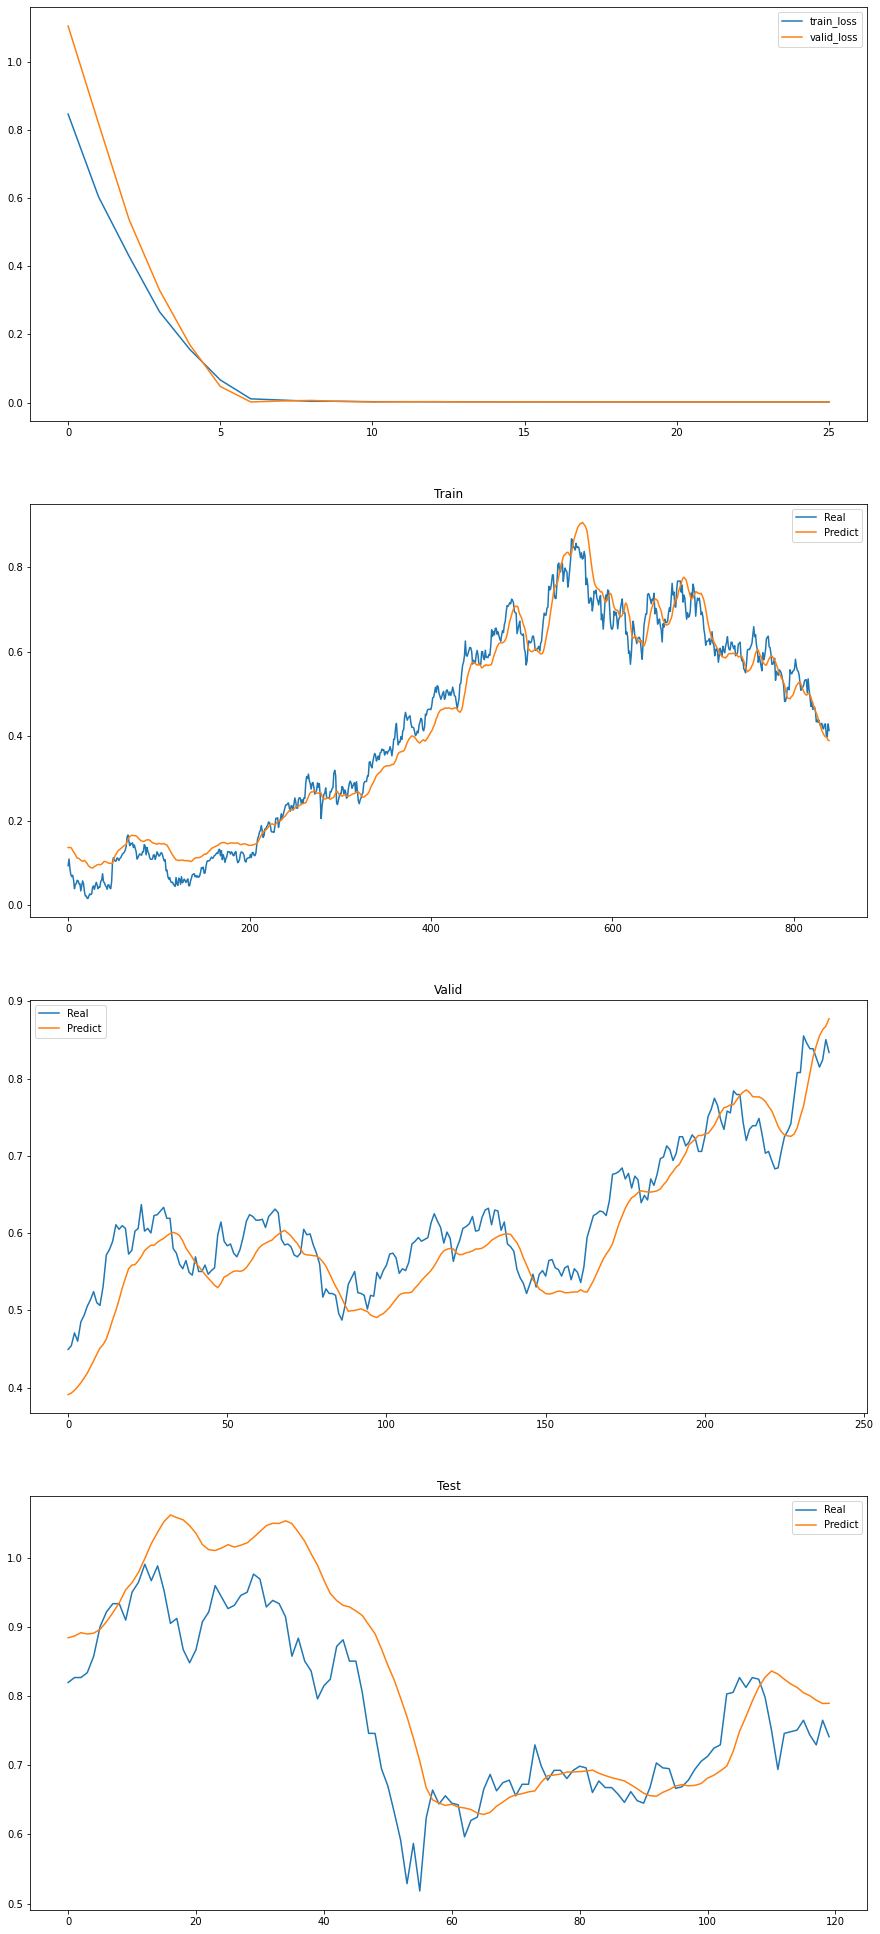

RMSE : 0.03839257641057185


In [59]:
L_node = 16
activation = 'relu'
optimizer = 'adam'
batch_size = 128
epochs = 100

trainPredict, validPredict, testPredict = model_1(trainX, trainY, validX, validY, testX, testY, 
                                                  L_node, 
                                                  activation, 
                                                  optimizer, 
                                                  batch_size,  
                                                  epochs)

### Test 3 - LSTM node*(8, 16, 32, 64) test*

- model : model_1(Simple LSTM)
- activation : 'relu'
- optimizer : adam
- batch_size : 8
- epochs : 100
- early_stopping : yes

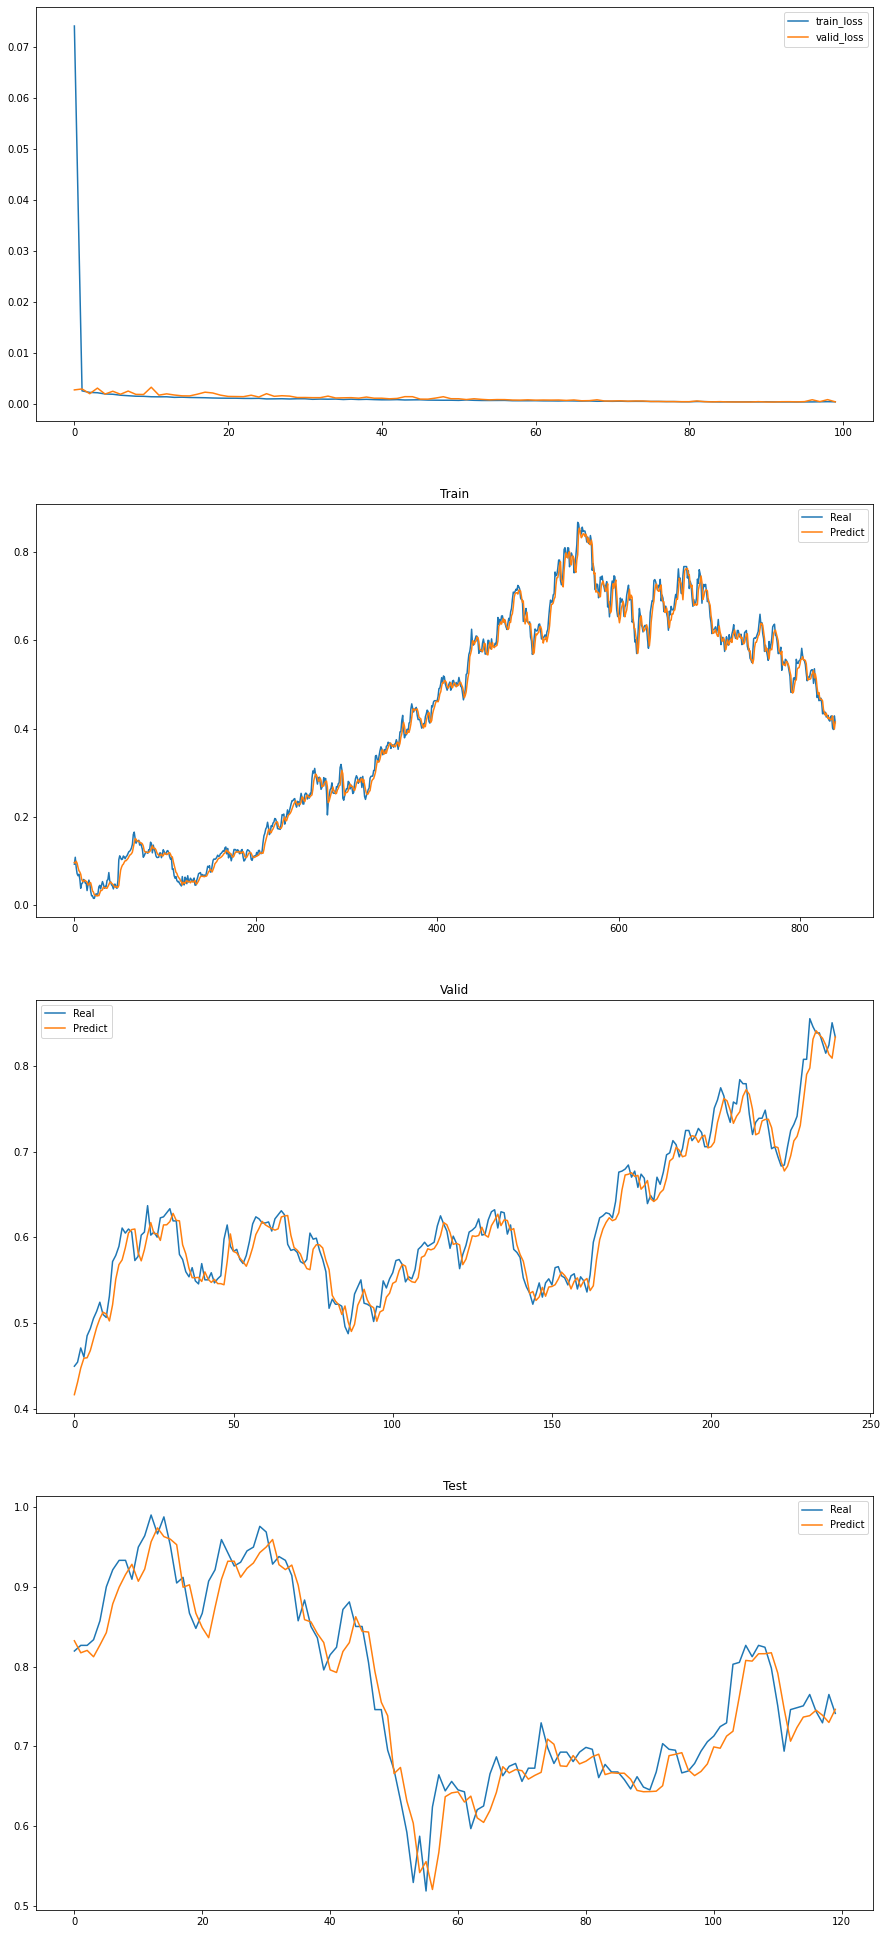

RMSE : 0.026940340657262595


In [60]:
L_node = 8
activation = 'relu'
optimizer = 'adam'
batch_size = 8
epochs = 100

trainPredict, validPredict, testPredict = model_1(trainX, trainY, validX, validY, testX, testY, 
                                                  L_node, 
                                                  activation, 
                                                  optimizer, 
                                                  batch_size,  
                                                  epochs)

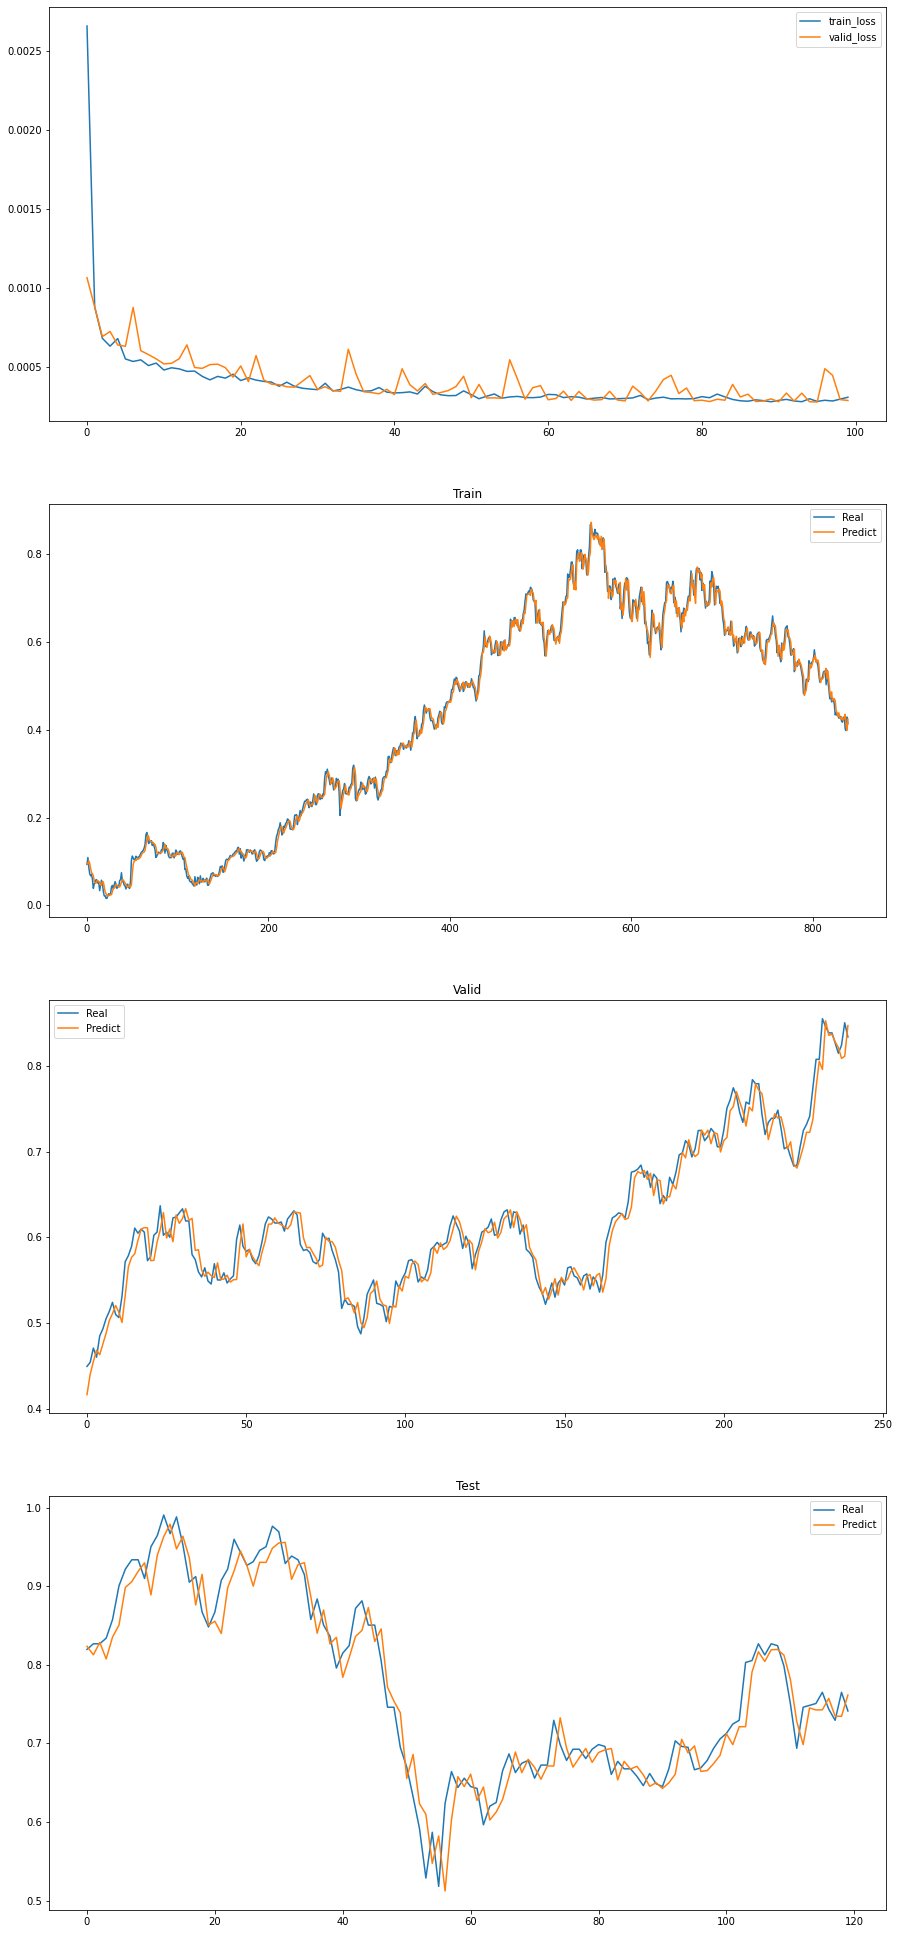

RMSE : 0.02642395520235121


In [61]:
L_node = 16
activation = 'relu'
optimizer = 'adam'
batch_size = 8
epochs = 100

trainPredict, validPredict, testPredict = model_1(trainX, trainY, validX, validY, testX, testY, 
                                                  L_node, 
                                                  activation, 
                                                  optimizer, 
                                                  batch_size,  
                                                  epochs)

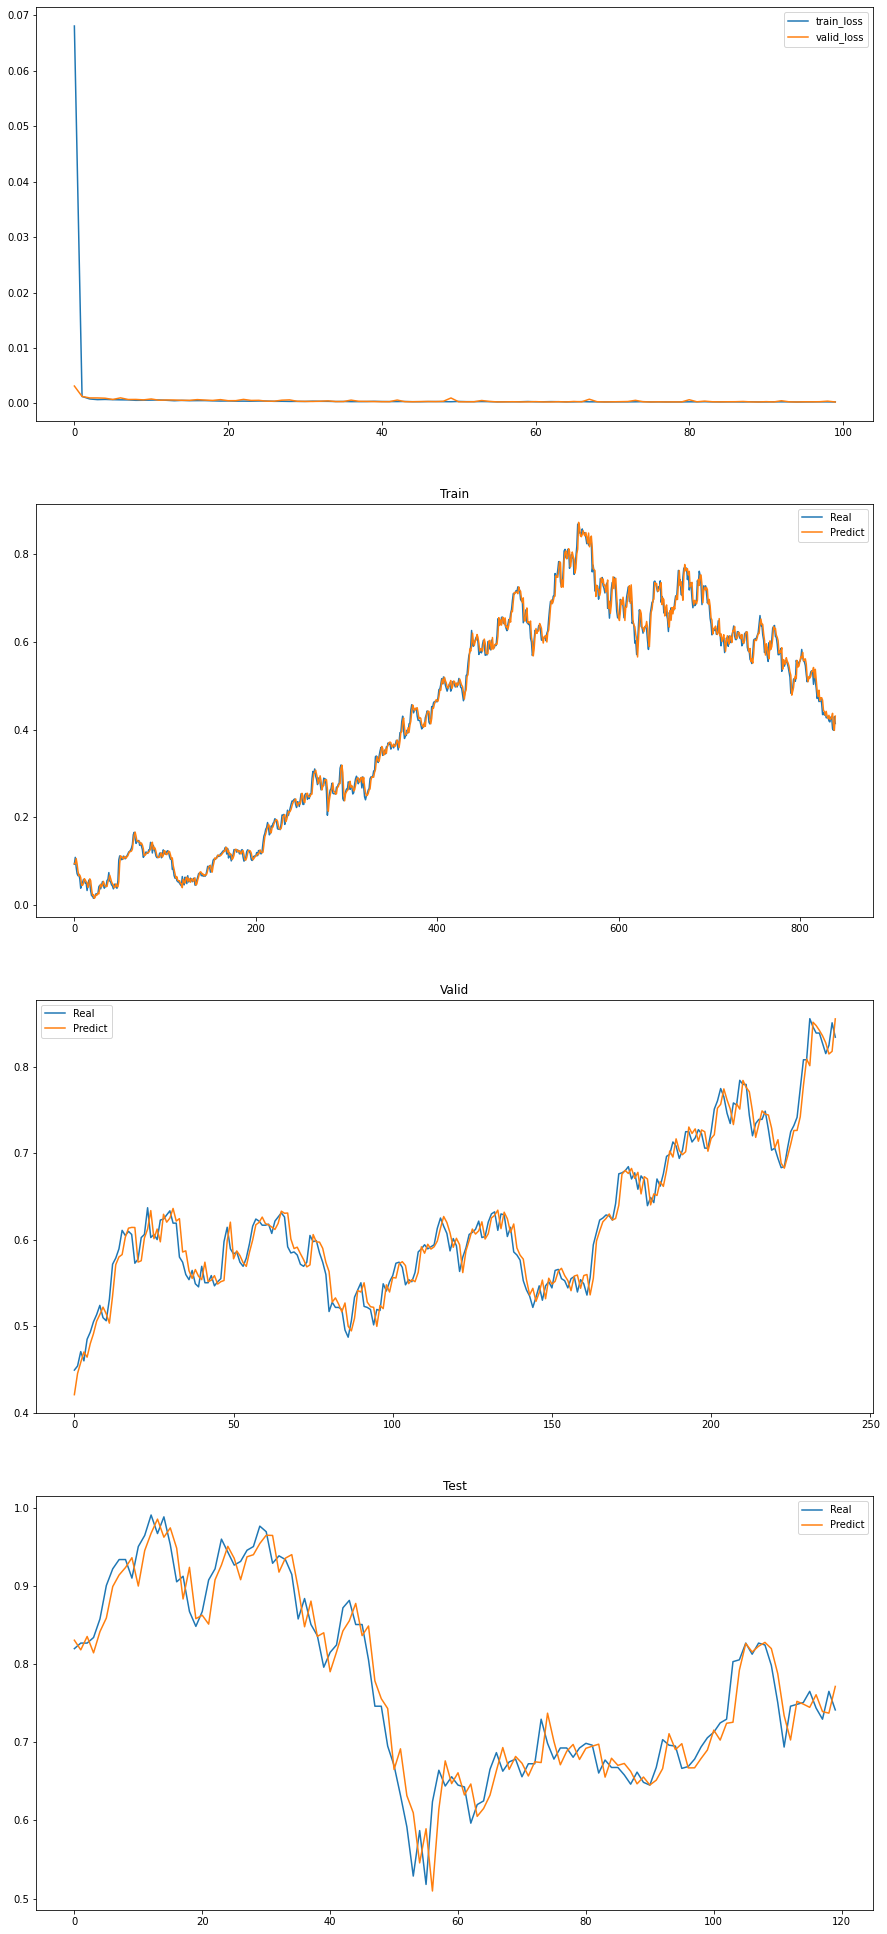

RMSE : 0.026812788560221092


In [62]:
L_node = 32
activation = 'relu'
optimizer = 'adam'
batch_size = 8
epochs = 100

trainPredict, validPredict, testPredict = model_1(trainX, trainY, validX, validY, testX, testY, 
                                                  L_node, 
                                                  activation, 
                                                  optimizer, 
                                                  batch_size,  
                                                  epochs)

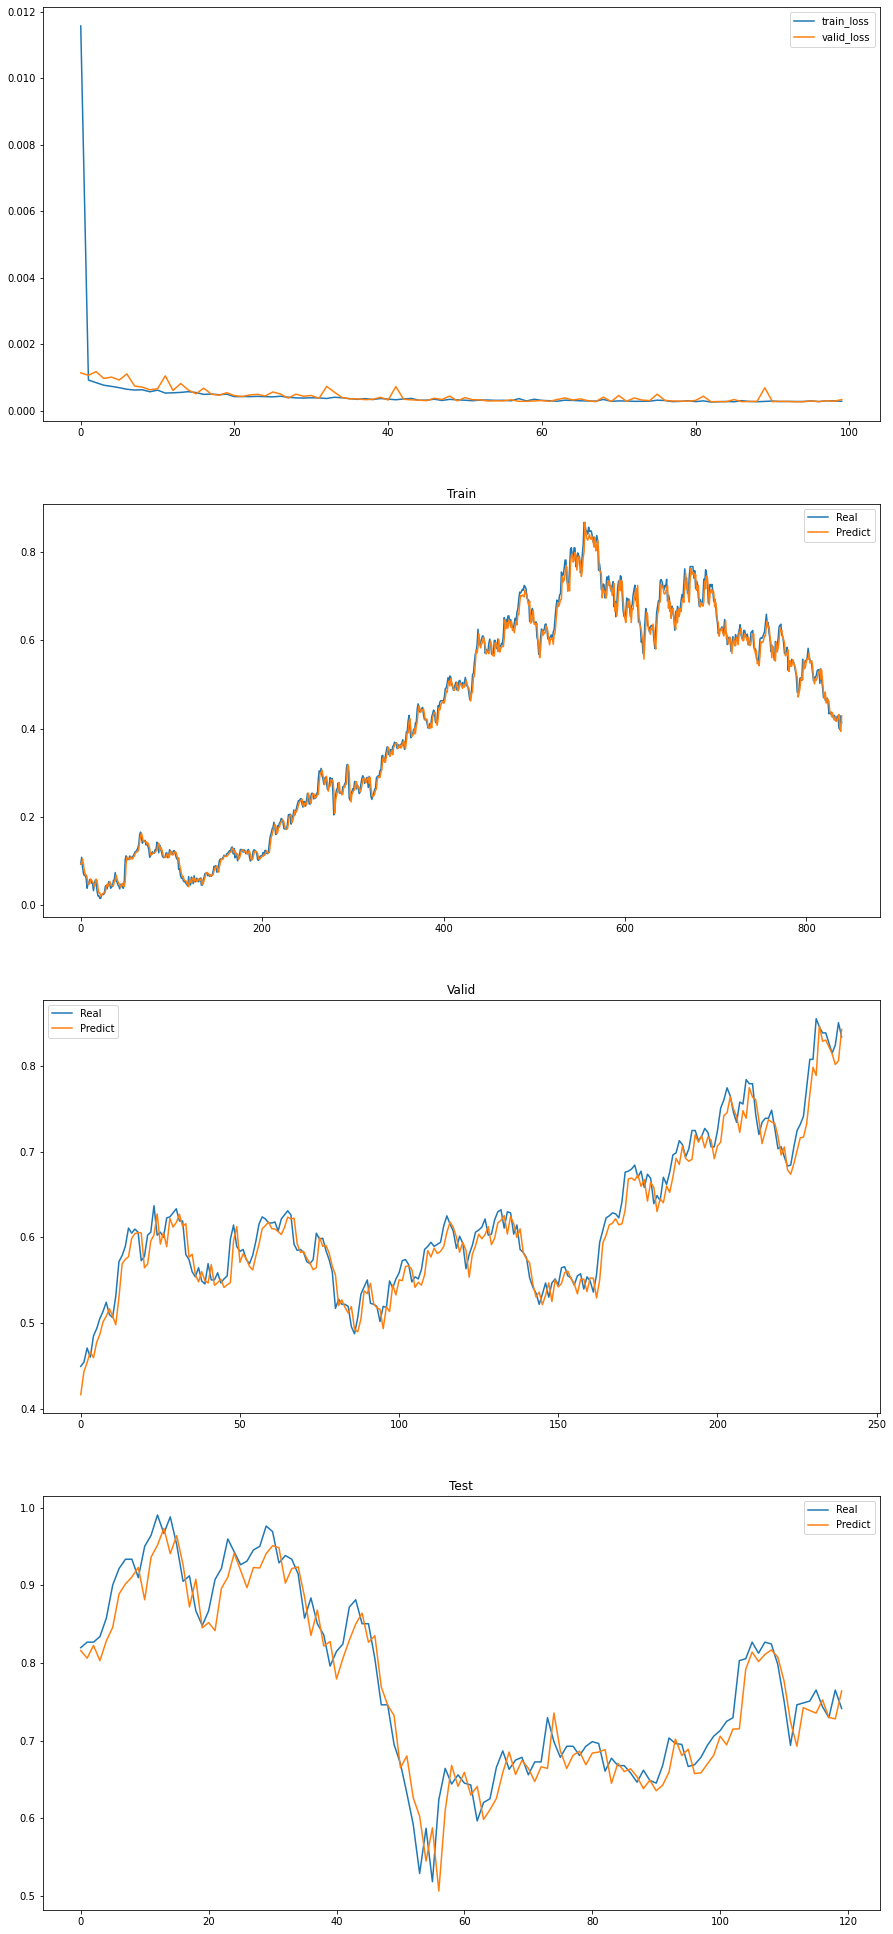

RMSE : 0.026313585651795927


In [63]:
L_node = 64
activation = 'relu'
optimizer = 'adam'
batch_size = 8
epochs = 100

trainPredict, validPredict, testPredict = model_1(trainX, trainY, validX, validY, testX, testY, 
                                                  L_node, 
                                                  activation, 
                                                  optimizer, 
                                                  batch_size,  
                                                  epochs)

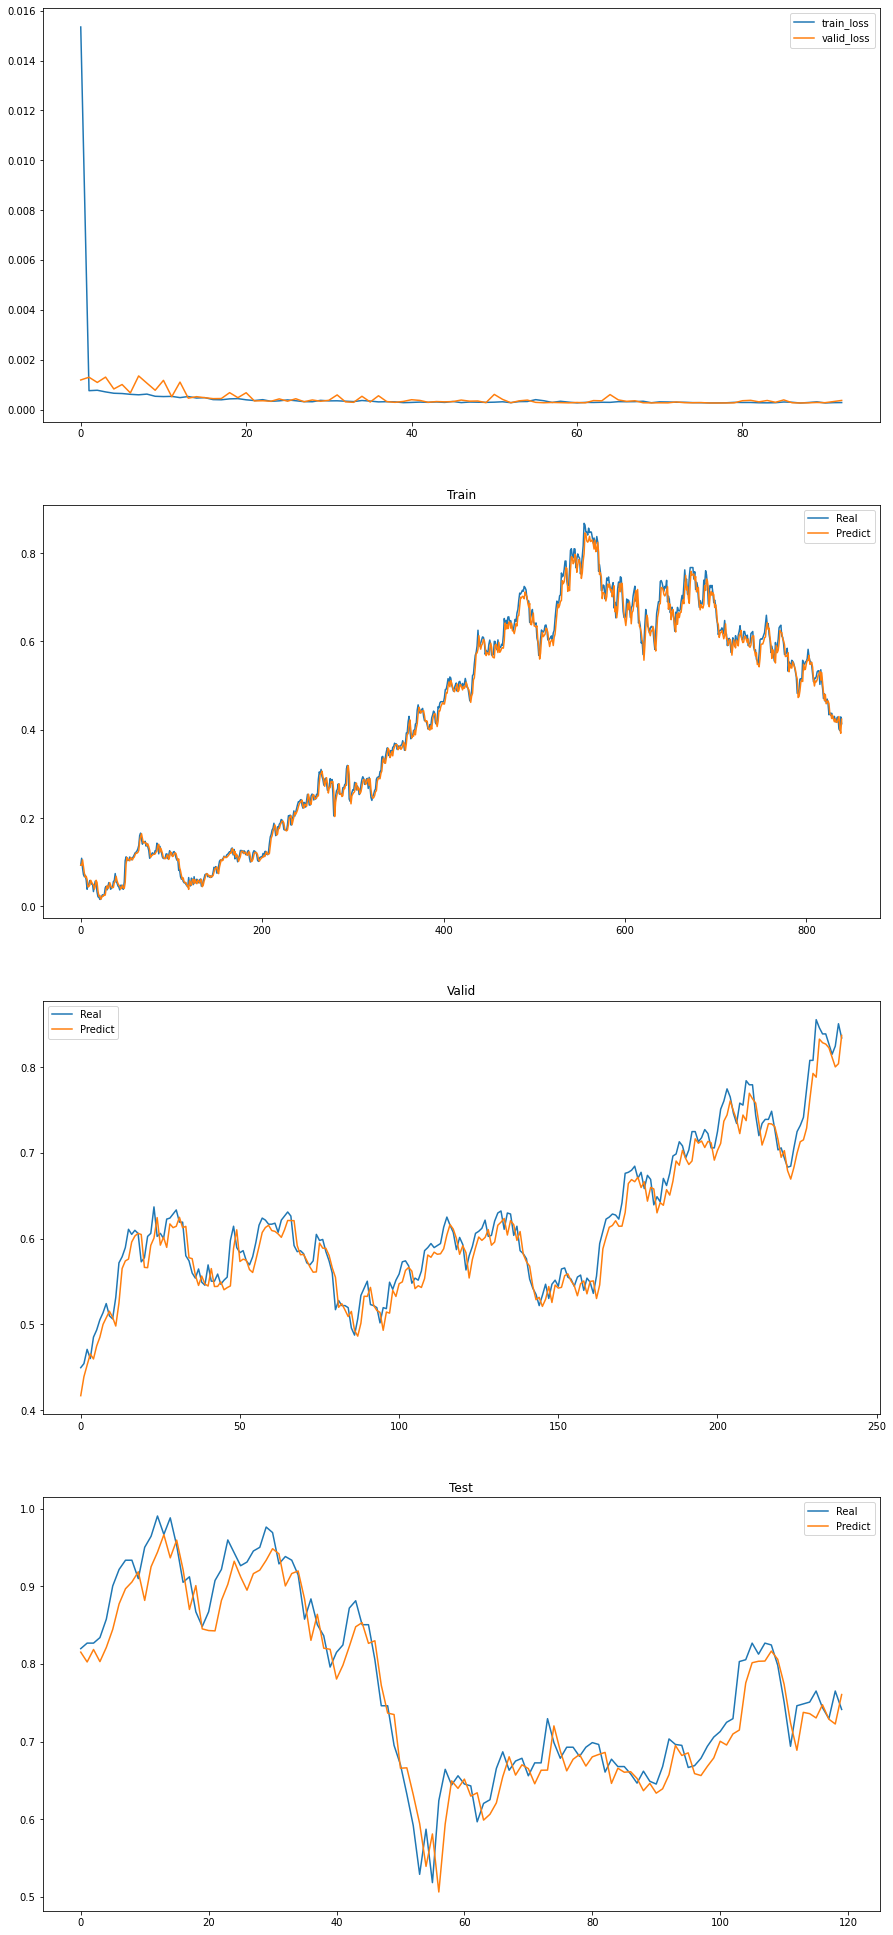

RMSE : 0.026224892894675757


In [64]:
L_node = 128
activation = 'relu'
optimizer = 'adam'
batch_size = 8
epochs = 100

trainPredict, validPredict, testPredict = model_1(trainX, trainY, validX, validY, testX, testY, 
                                                  L_node, 
                                                  activation, 
                                                  optimizer, 
                                                  batch_size,  
                                                  epochs)

### Test 4 - activation*(tanh, relu, sigmoid) test*

- model : model_1(Simple LSTM)
- LSTM node : 128
- optimizer : adam
- batch_size : 8
- epochs : 100
- early_stopping : yes

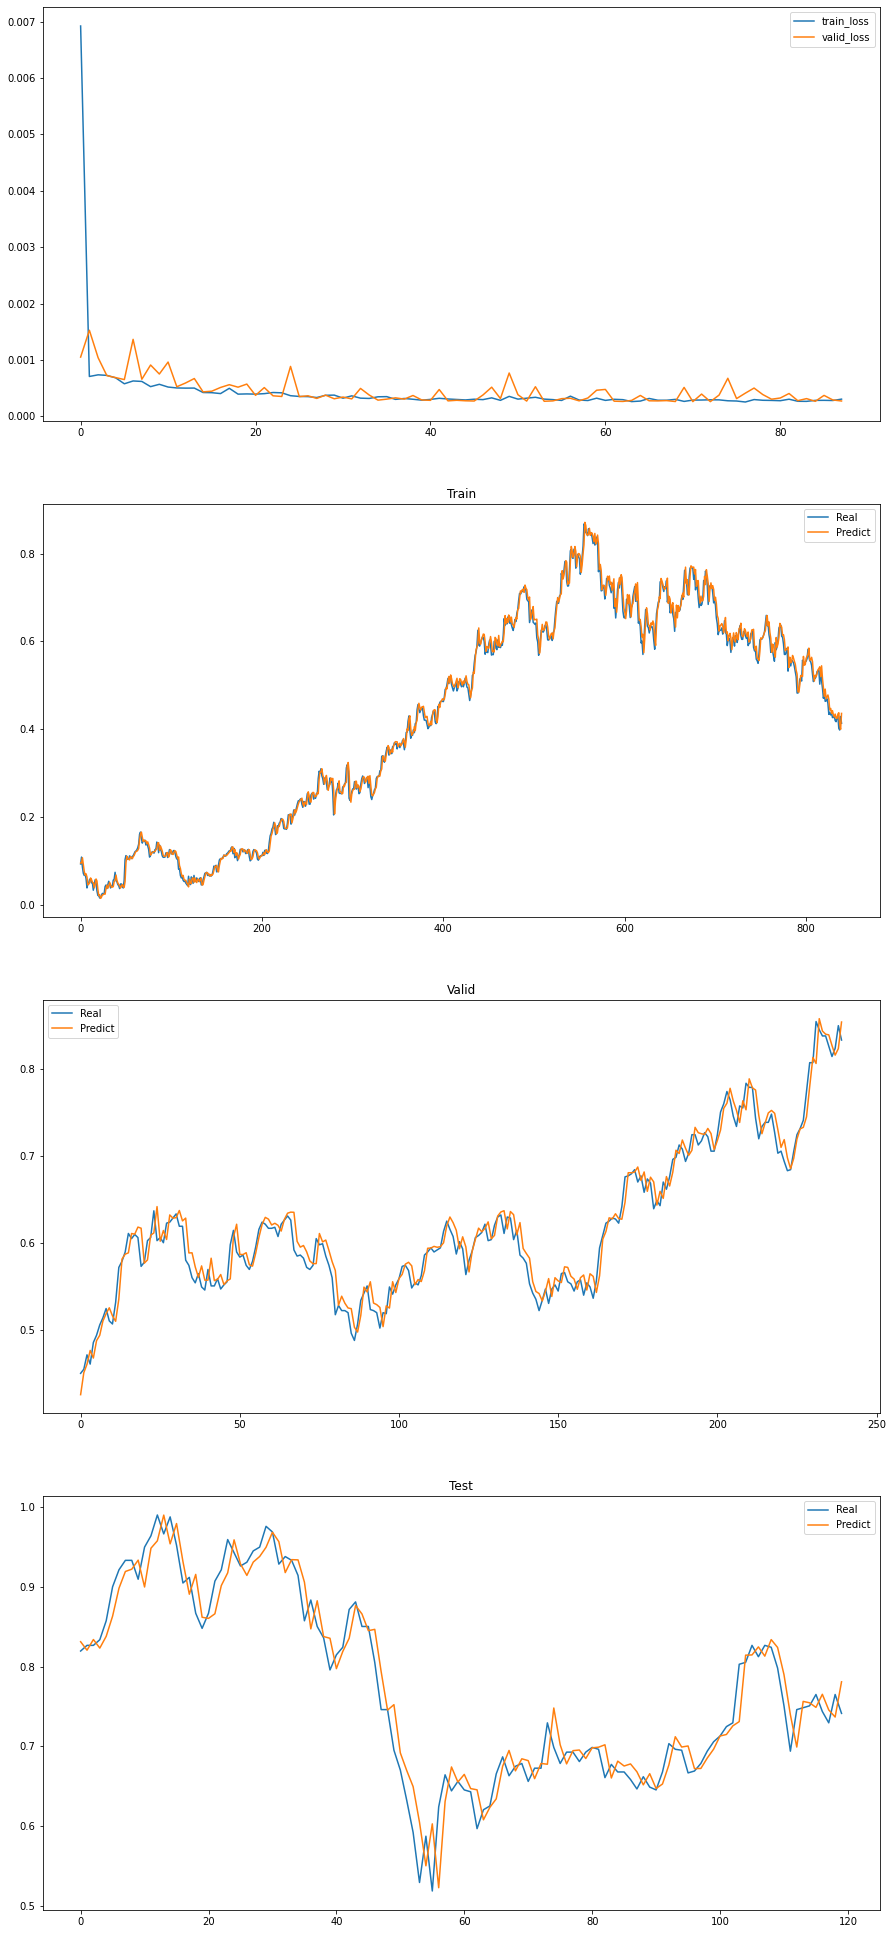

RMSE : 0.026265035729029405


In [65]:
L_node = 128
activation = 'tanh'
optimizer = 'adam'
batch_size = 8
epochs = 100

trainPredict, validPredict, testPredict = model_1(trainX, trainY, validX, validY, testX, testY, 
                                                  L_node, 
                                                  activation, 
                                                  optimizer, 
                                                  batch_size,  
                                                  epochs)

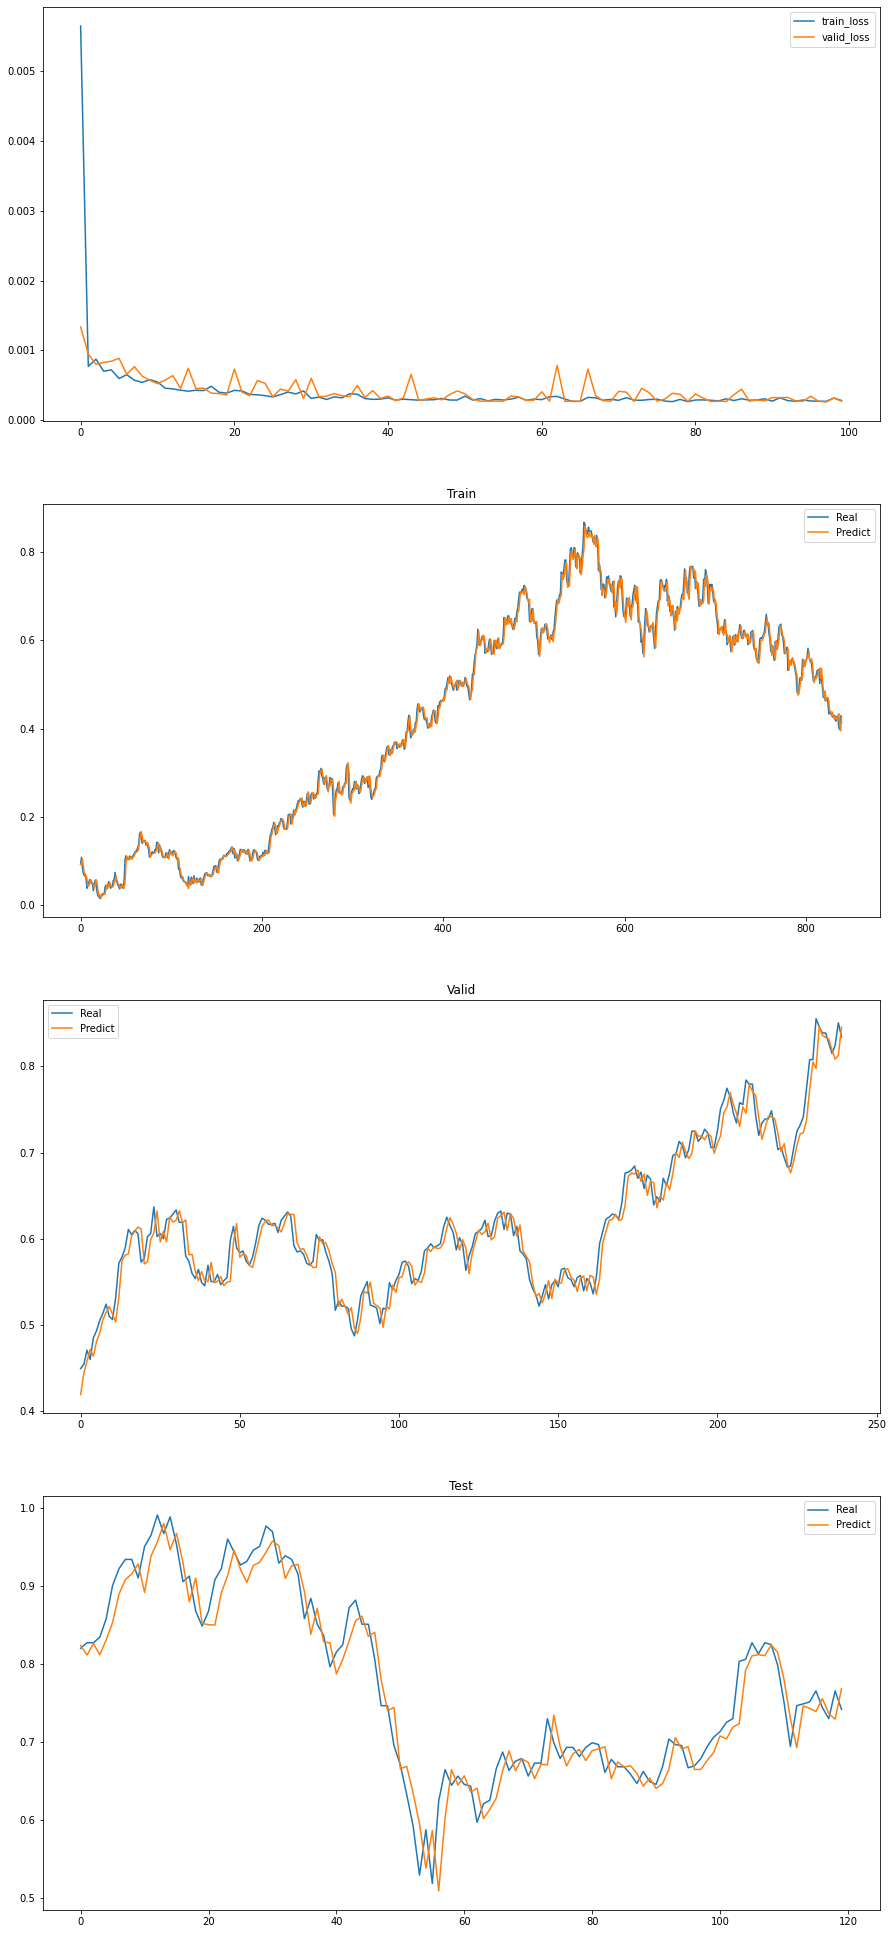

RMSE : 0.026369396538001647


In [66]:
L_node = 128
activation = 'relu'
optimizer = 'adam'
batch_size = 8
epochs = 100

trainPredict, validPredict, testPredict = model_1(trainX, trainY, validX, validY, testX, testY, 
                                                  L_node, 
                                                  activation, 
                                                  optimizer, 
                                                  batch_size,  
                                                  epochs)

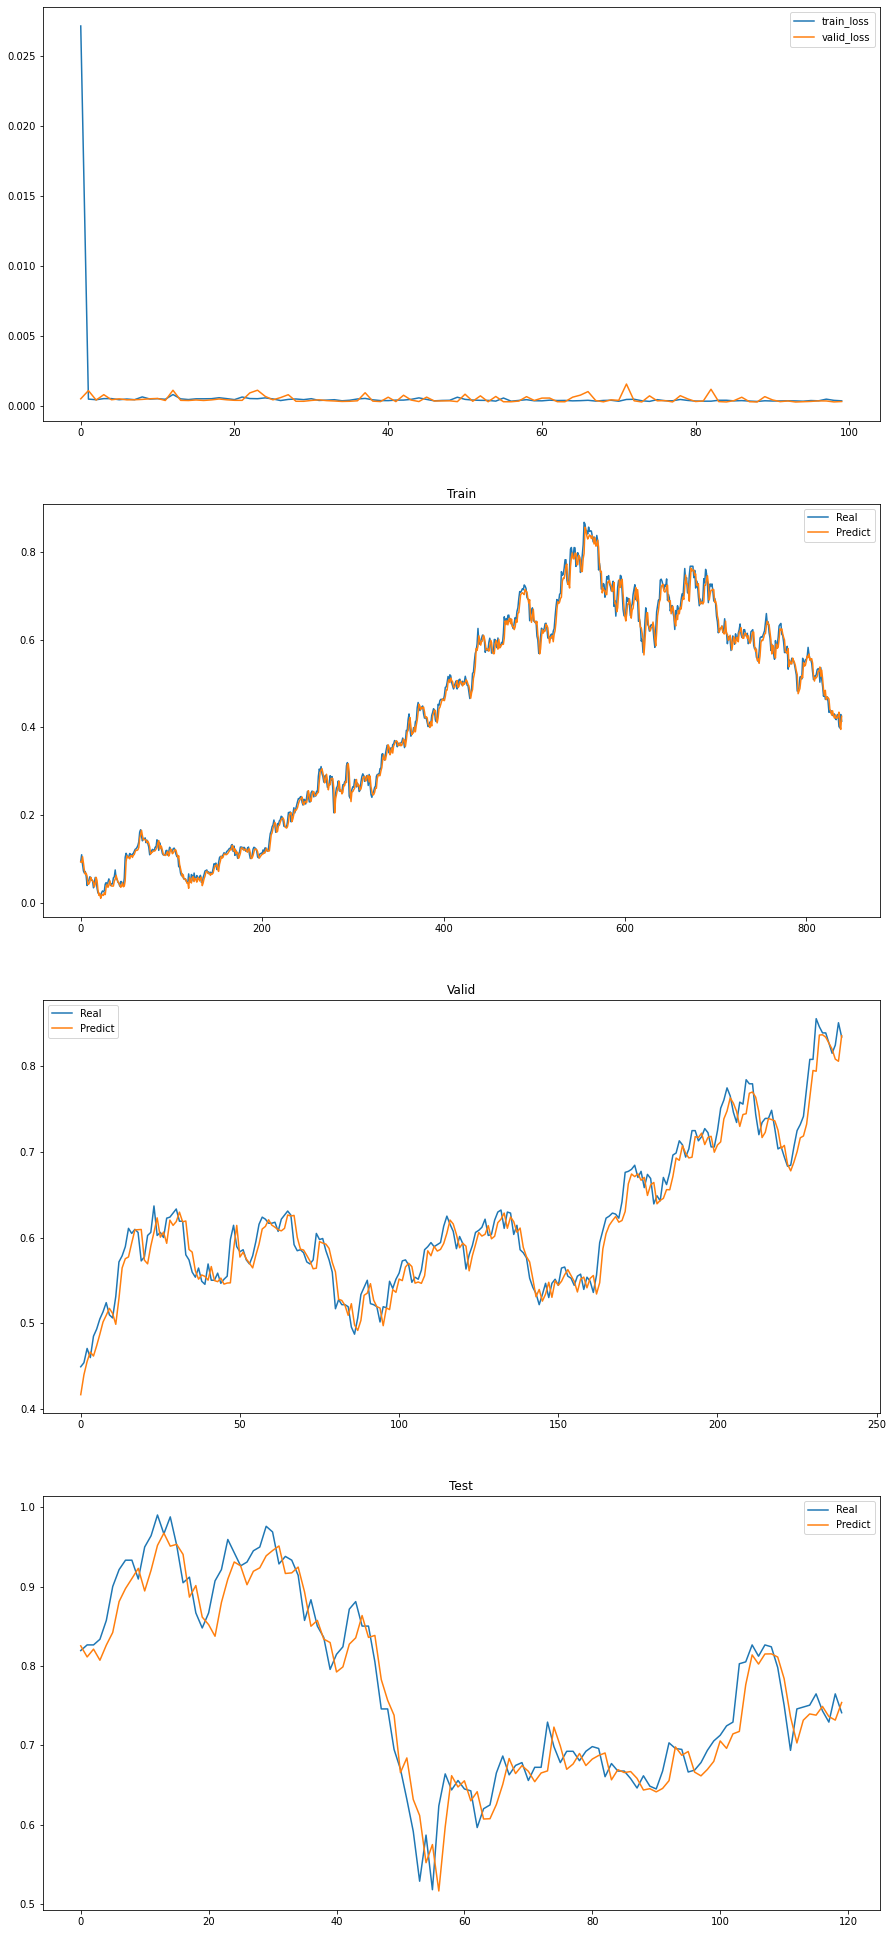

RMSE : 0.026100215259276457


In [67]:
L_node = 128
activation = 'sigmoid'
optimizer = 'adam'
batch_size = 8
epochs = 100

trainPredict, validPredict, testPredict = model_1(trainX, trainY, validX, validY, testX, testY, 
                                                  L_node, 
                                                  activation, 
                                                  optimizer, 
                                                  batch_size,  
                                                  epochs)

## Section 2. model_2(added fully connected layer)
 
- model : model_2(added fully connected layer)
- LSTM node : 128
- activation : 'tanh'
- optimizer : 'adam'
- batch_size : 8
- dropout = 0.15
- epochs : 100
- early_stopping : yes

### Test 1 - Dense node*(8, 16, 32, 64) test*

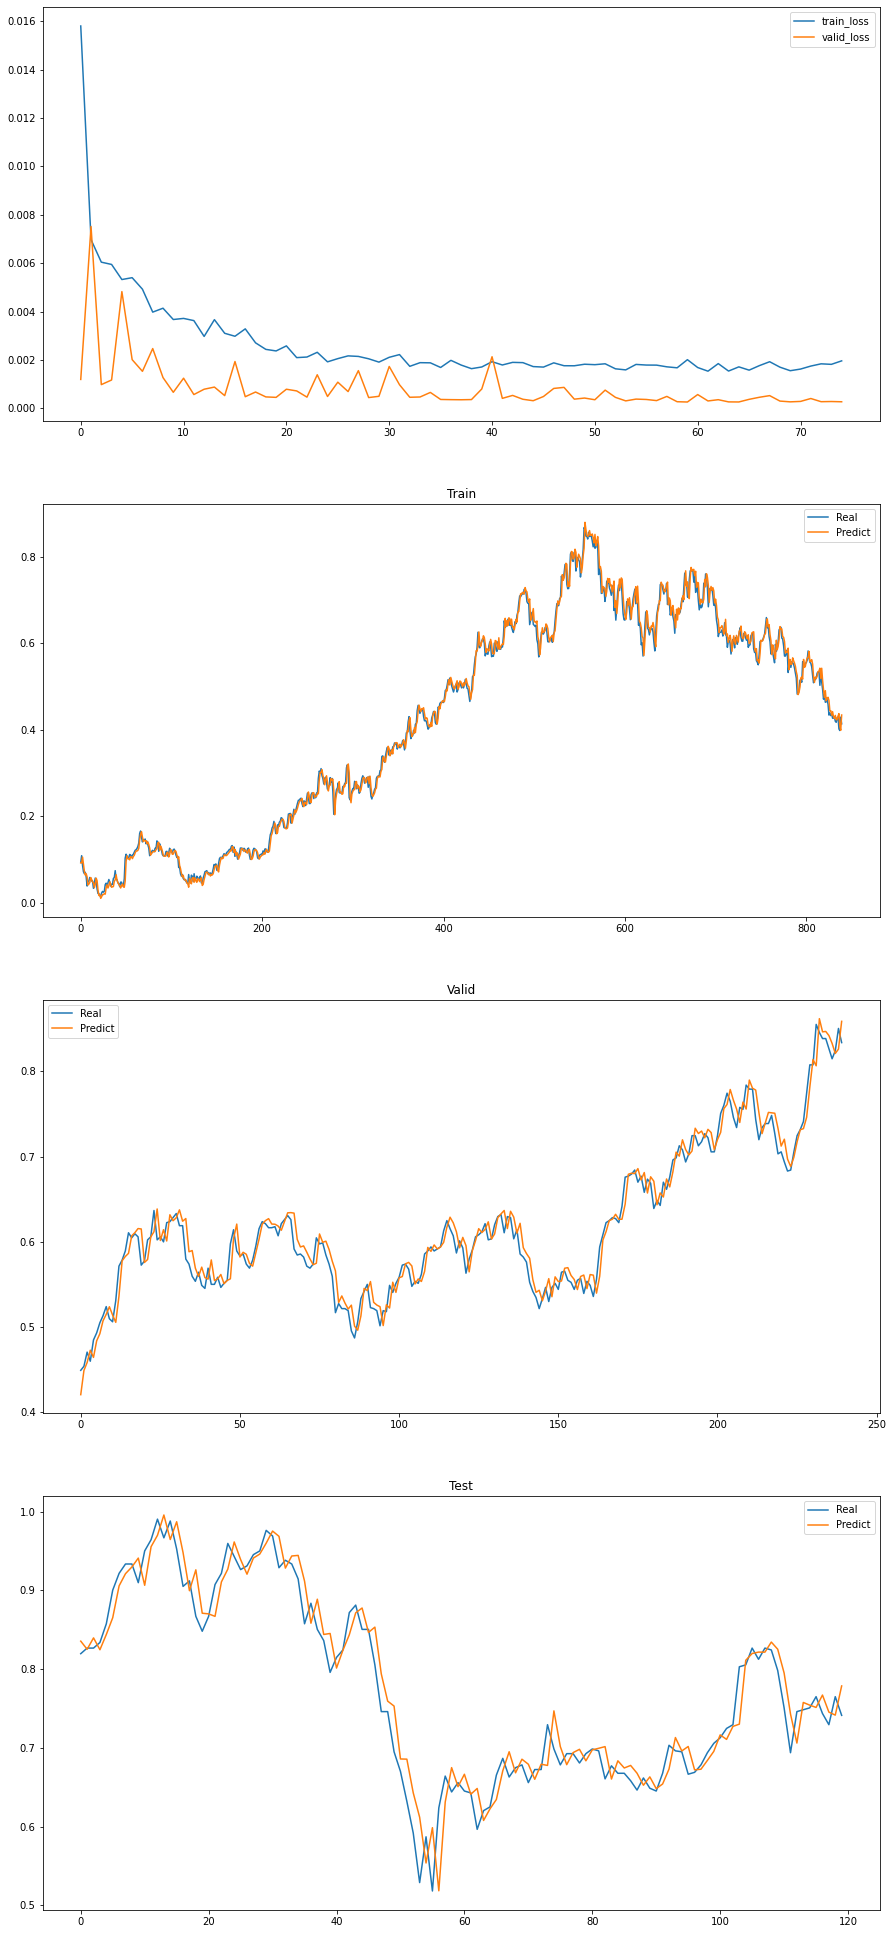

RMSE : 0.027011669218639147


In [68]:
L_node = 128
activation = 'tanh'
optimizer = 'adam'
batch_size = 8
D_node = 8
dropout = .15
epochs = 100

trainPredict, validPredict, testPredict = model_2(trainX, trainY, validX, validY, testX, testY,                                                   
                                                  L_node, 
                                                  activation,
                                                  optimizer, 
                                                  batch_size, 
                                                  D_node, 
                                                  dropout, 
                                                  epochs)

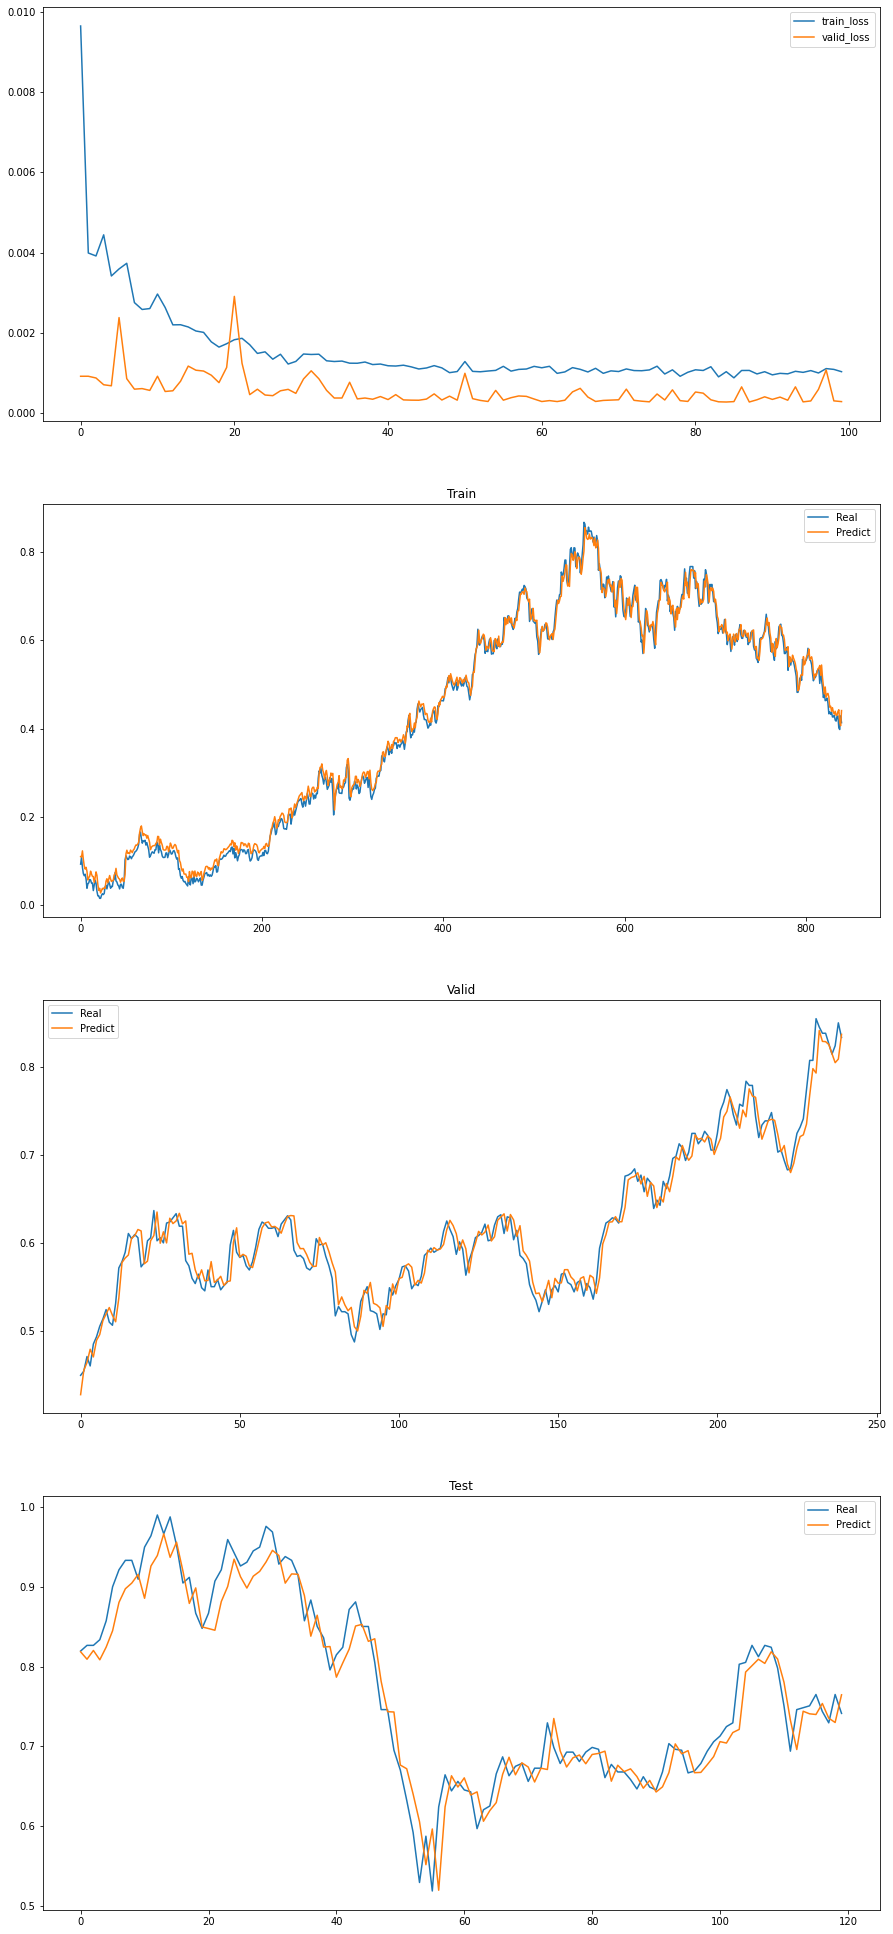

RMSE : 0.02521106788867447


In [69]:
L_node = 128
activation = 'tanh'
optimizer = 'adam'
batch_size = 8
D_node = 16
dropout = .15
epochs = 100

trainPredict, validPredict, testPredict = model_2(trainX, trainY, validX, validY, testX, testY,                                                 
                                                  L_node, 
                                                  activation,
                                                  optimizer, 
                                                  batch_size, 
                                                  D_node, 
                                                  dropout, 
                                                  epochs)

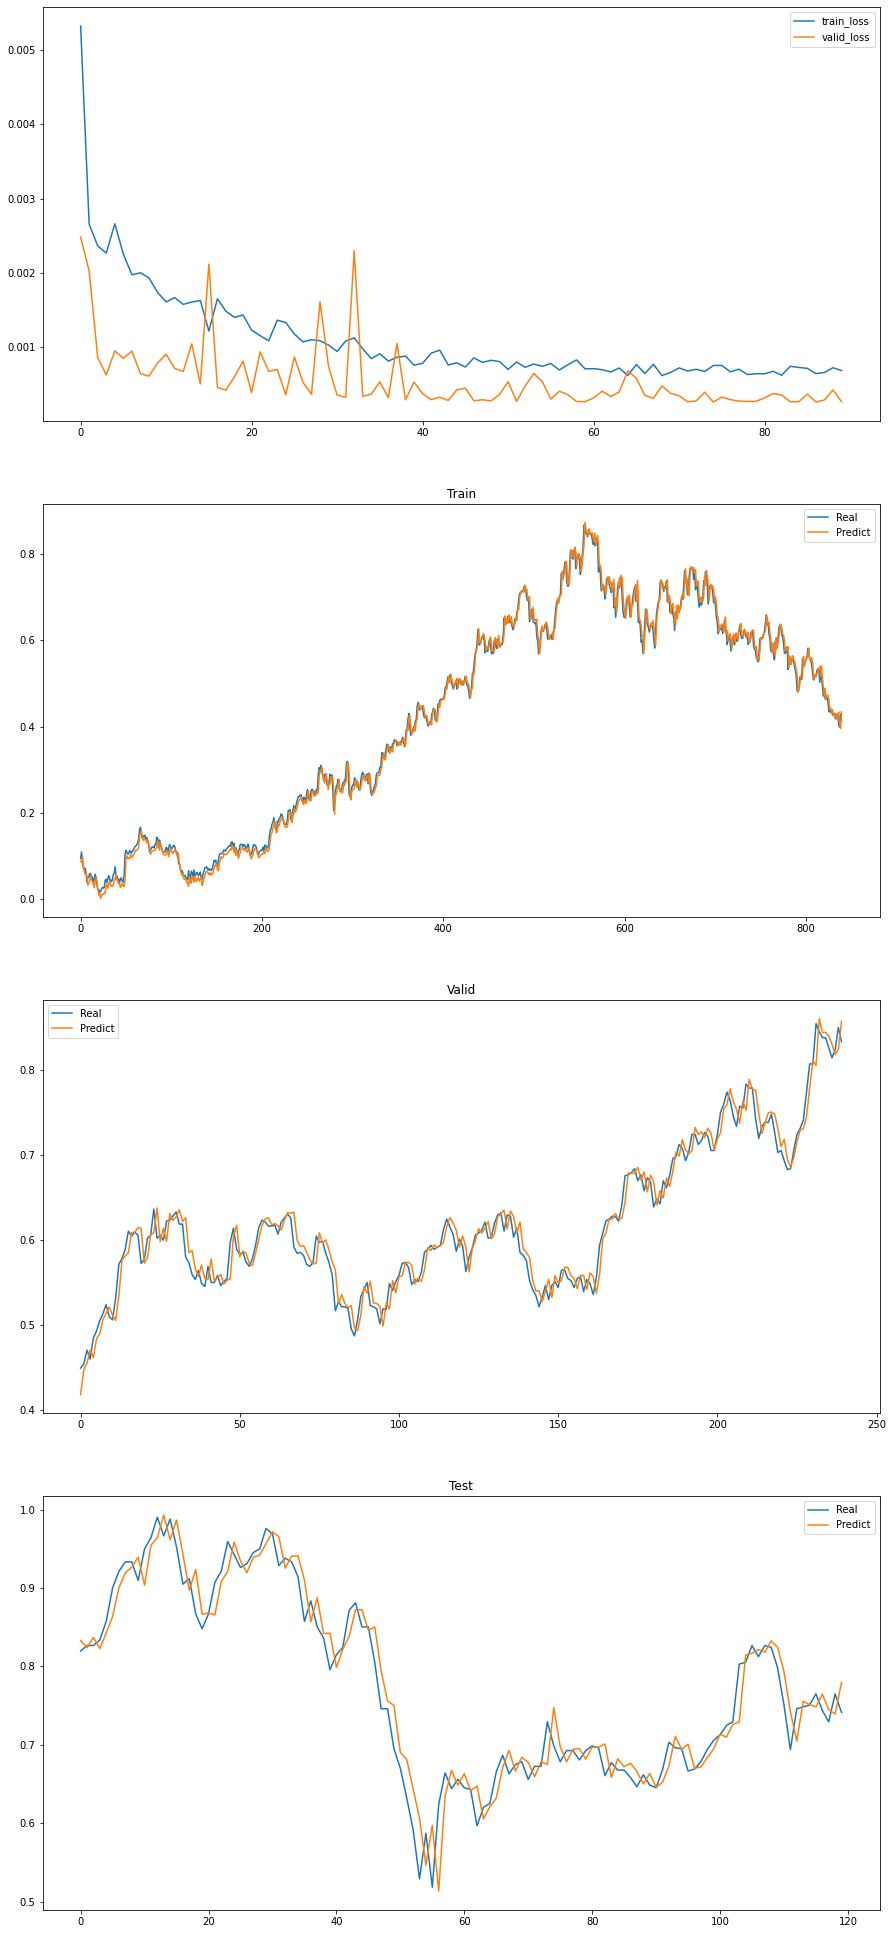

RMSE : 0.02692846480280028


In [70]:
L_node = 128
activation = 'tanh'
optimizer = 'adam'
batch_size = 8
D_node = 32
dropout = .15
epochs = 100

trainPredict, validPredict, testPredict = model_2(trainX, trainY, validX, validY, testX, testY,                                                   
                                                  L_node, 
                                                  activation,
                                                  optimizer, 
                                                  batch_size, 
                                                  D_node, 
                                                  dropout, 
                                                  epochs)

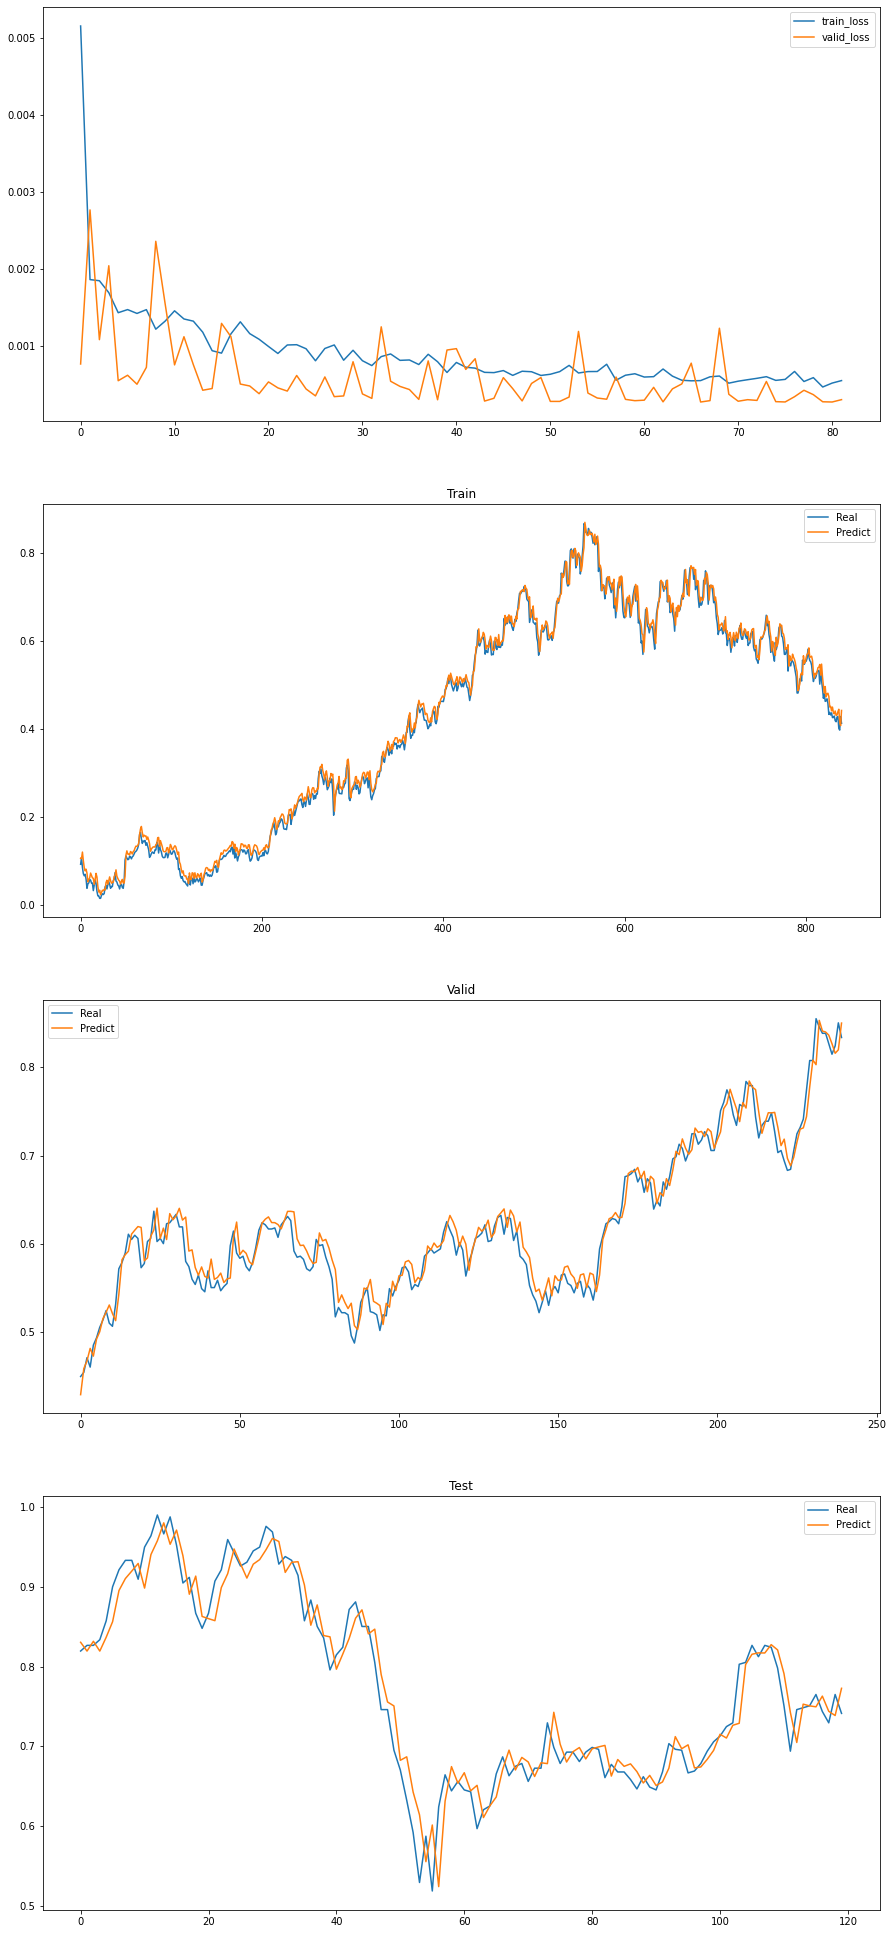

RMSE : 0.025852881508183146


In [71]:
L_node = 128
activation = 'tanh'
optimizer = 'adam'
batch_size = 8
D_node = 64
dropout = .15
epochs = 100

L_node, activation, optimizer, batch_size, D_node, dropout, epochs

trainPredict, validPredict, testPredict = model_2(trainX, trainY, validX, validY, testX, testY,                                                   
                                                  L_node,
                                                  activation,
                                                  optimizer, 
                                                  batch_size, 
                                                  D_node, 
                                                  dropout, 
                                                  epochs)

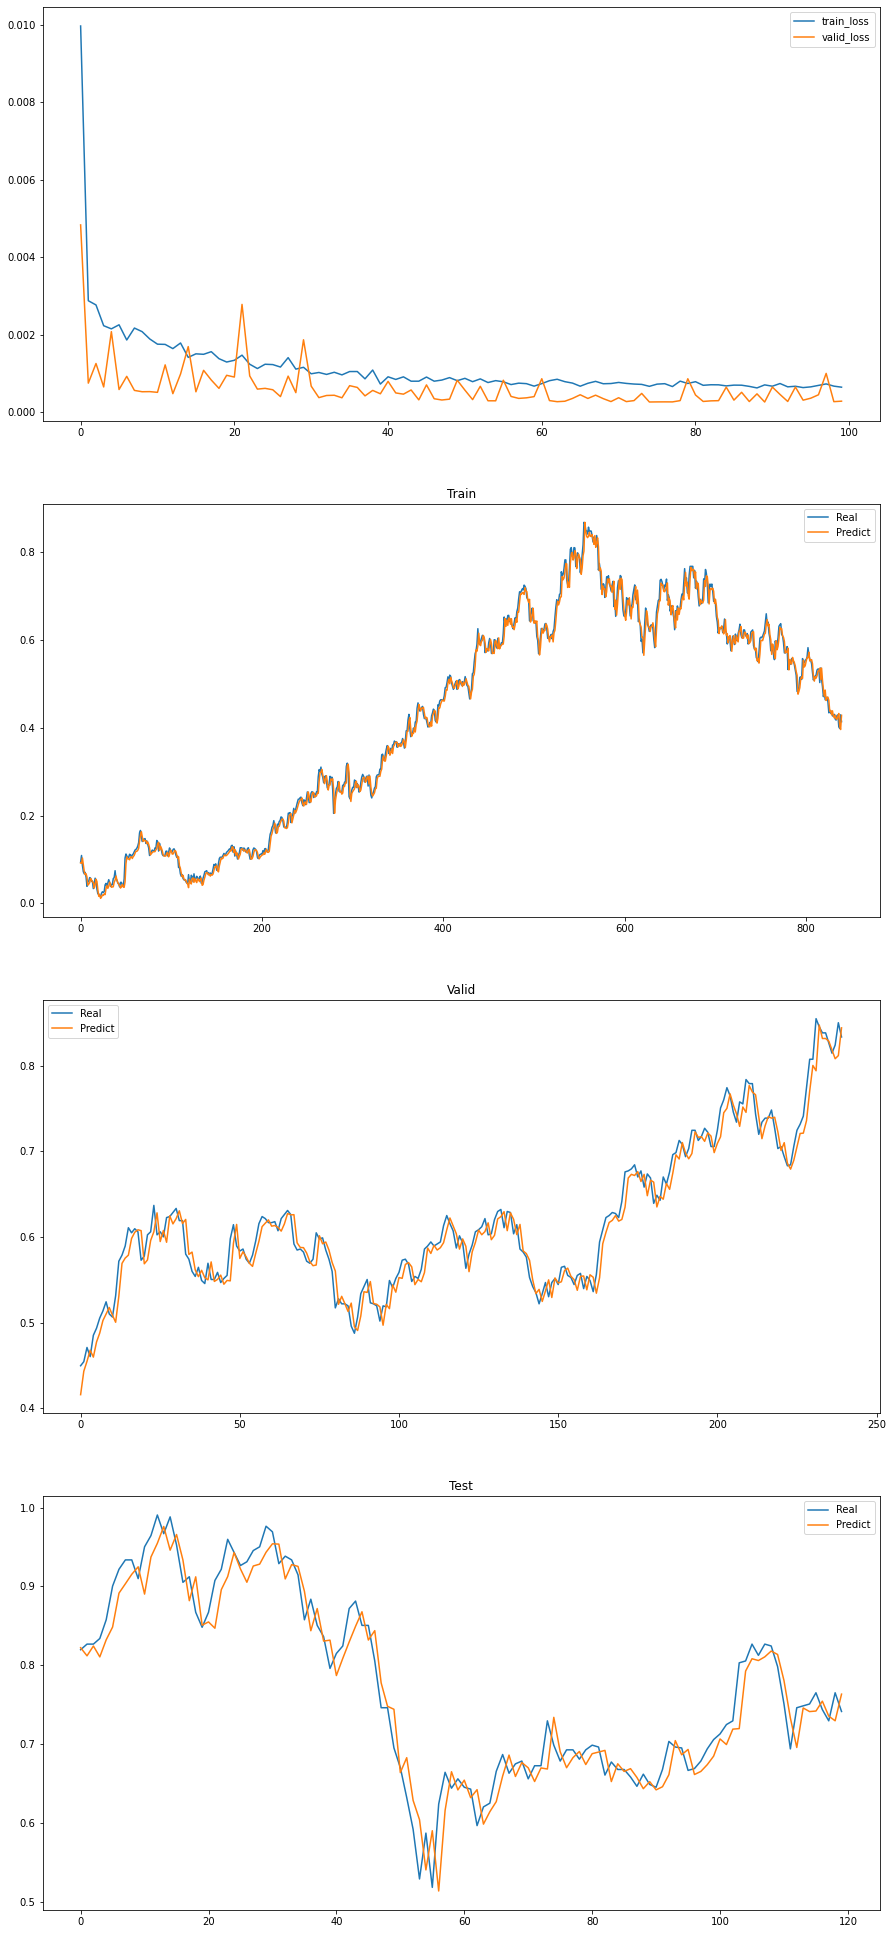

RMSE : 0.026336232219853054


In [72]:
L_node = 64
activation = 'tanh'
optimizer = 'adam'
batch_size = 8
D_node = 32
dropout = .15
epochs = 100

L_node, activation, optimizer, batch_size, D_node, dropout, epochs

trainPredict, validPredict, testPredict = model_2(trainX, trainY, validX, validY, testX, testY,                                                   
                                                  L_node,
                                                  activation,
                                                  optimizer, 
                                                  batch_size, 
                                                  D_node, 
                                                  dropout, 
                                                  epochs)

## Section 3. Add Market Index

- model : model_2(added fully connected layer)
- LSTM node : 64
- activation : 'tanh'
- optimizer : 'adam'
- batch_size : 8
- Dense node : 64
- dropout : 0.15
- epochs : 100
- early_stopping : yes

In [73]:
df_im = pd.merge(df_m, df_i, on='Date')
df_im.head()

High_x        Low_x       Open_x      Close_x   High_y  \
Date                                                                      
2015-06-30  2075.020020  2049.439941  2054.830078  2074.199951  25700.0   
2015-07-01  2100.340088  2072.540039  2077.270020  2097.889893  26040.0   
2015-07-02  2110.810059  2098.760010  2107.110107  2107.330078  26080.0   
2015-07-03  2109.679932  2094.020020  2107.510010  2104.409912  25880.0   
2015-07-06  2089.860107  2052.229980  2076.060059  2053.929932  25200.0   

              Low_y   Open_y  Close_y  
Date                                   
2015-06-30  25320.0  25520.0  25360.0  
2015-07-01  25180.0  25360.0  25900.0  
2015-07-02  25700.0  25720.0  25980.0  
2015-07-03  25340.0  25740.0  25360.0  
2015-07-06  24460.0  25060.0  24600.0

In [74]:
trainX, trainY, validX, validY, testX, testY = preprocessing(df_im, 20)

trainX shape : (837, 20, 8)
trainY shape : (837,)
validX shape : (239, 20, 8)
validY shape : (239,)
testX shape : (121, 20, 8)
testY shape : (121,)


In [75]:
L_node = 128
activation = 'tanh'
optimizer = 'adam'
batch_size = 8
D_node = 64
dropout = .15
epochs = 100

In [76]:
model = Sequential()
model.add(LSTM(L_node, activation=activation, input_shape=(20, 8)))
model.add(Dense(D_node))
model.add(Dropout(dropout))
model.add(Dense(1))

In [77]:
### training ###
model.compile(optimizer=optimizer, loss='mse')
es = EarlyStopping(monitor='val_loss', patience=15)

history = model.fit(trainX, trainY, 
                    validation_data=(validX, validY),
                    epochs=epochs, 
                    batch_size=batch_size,
                    callbacks=[es],
                    verbose=0)

trainPredict = model.predict(trainX)
validPredict = model.predict(validX)
testPredict = model.predict(testX)

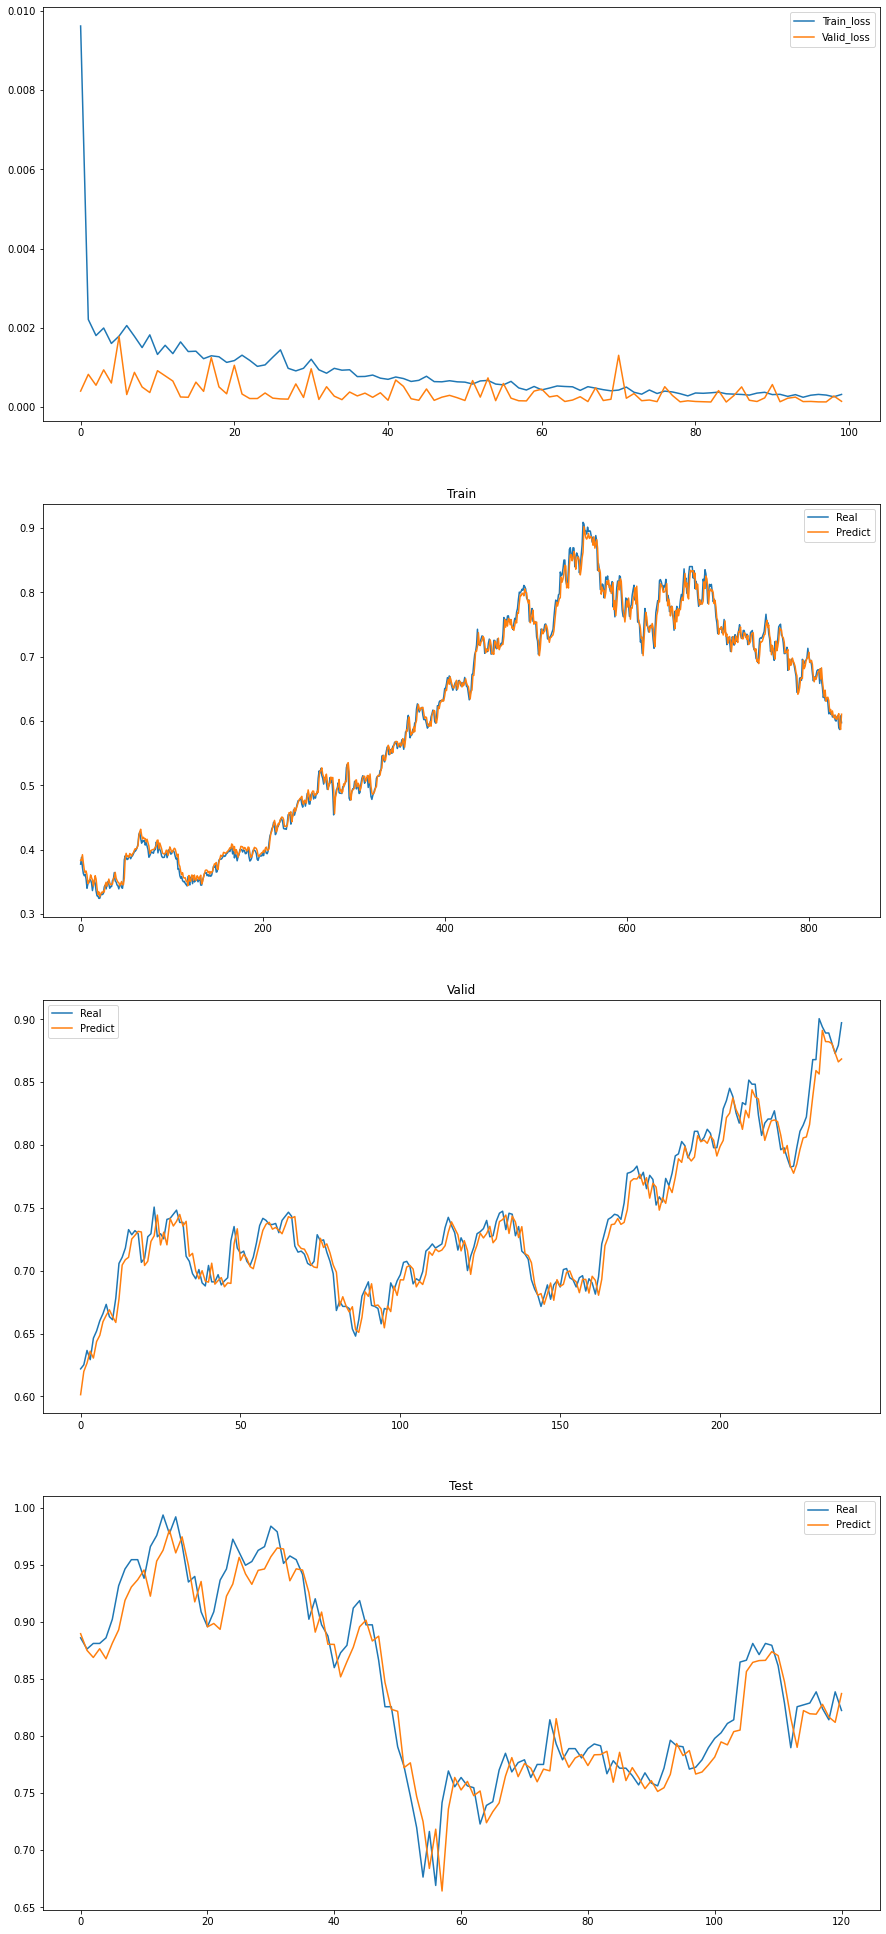

In [78]:
## visualization
fig, ax = plt.subplots(4, 1, figsize=(15, 35))

ax[0].plot(history.history['loss'])
ax[0].plot(history.history['val_loss'])
ax[0].legend(['Train_loss', 'Valid_loss'])

ax[1].plot(trainY)
ax[1].plot(trainPredict)
ax[1].set_title('Train')
ax[1].legend(['Real', 'Predict'])

ax[2].plot(validY)
ax[2].plot(validPredict)
ax[2].set_title('Valid')
ax[2].legend(['Real', 'Predict'])


ax[3].plot(testY)
ax[3].plot(testPredict)
ax[3].set_title('Test')
ax[3].legend(['Real', 'Predict'])
plt.show()

In [79]:
print(f"RMSE : {float(np.mean((testPredict-testY)**2))}")

RMSE : 0.01224830599239481


## Section 4. Predict 5-days stock movements

In [73]:
def visualization_flow(true, pred):
    plt.plot(true[-1], 'mediumslateblue', marker='o')
    plt.plot(pred[-1], 'orange', marker='o')
    plt.legend(['Real', 'Pred'])

    xticks_li = []
    for i in range(len(true[-1])):
        xticks_li.append('t=' + str(i))

    plt.xticks(np.arange(len(true[-1])), xticks_li)

    for x,y,z in zip(np.arange(0,6), true[-1], pred[-1]):

        label1 = "{:.2f}".format(y)
        label2 = "{:.2f}".format(z)

        plt.annotate(label1, # this is the text
                     (x,y), # this is the point to label
                     textcoords="offset points", # how to position the text
                     xytext=(20,10), # distance from text to points (x,y)
                     ha='center') # horizontal alignment can be left, right or center

        plt.annotate(label2, # this is the text
                     (x,z), # this is the point to label
                     textcoords="offset points", # how to position the text
                     xytext=(20,10), # distance from text to points (x,y)
                     ha='center') # horizontal alignment can be left, right or center

    plt.show()

In [74]:
def preprocess_flow(df, seq_length, predict_day):
    df_mat = df.to_numpy()
    data = min_max_scaling(df_mat)
    
    dataX = []
    dataY= []

    for i in range(0, len(data) - seq_length - predict_day):
        _x = data[i:i + seq_length]
        _y = data[:, -1][i + seq_length:i + seq_length + predict_day]
        dataX.append(_x)
        dataY.append(_y)
        
    ## split train, valid, test ##  
    train_size = int(len(dataY) * 0.7)
    valid_size = int(len(dataY) * 0.2)
    test_size = len(dataY) - train_size - valid_size
    
    trainX = np.array(dataX[0:train_size])
    trainY = np.array(dataY[0:train_size])

    validX = np.array(dataX[train_size:train_size+valid_size])
    validY = np.array(dataY[train_size:train_size+valid_size])

    testX = np.array(dataX[train_size+valid_size:])
    testY = np.array(dataY[train_size+valid_size:])
    
    print(f'trainX shape : {trainX.shape}')
    print(f'trainY shape : {trainY.shape}')

    print(f'validX shape : {validX.shape}')
    print(f'validY shape : {validY.shape}')

    print(f'testX shape : {testX.shape}')
    print(f'testY shape : {testY.shape}')
    
    return df_mat, trainX, trainY, validX, validY, testX, testY

In [75]:
def model_1_flow(df_mat, trainX, trainY, validX, validY, testX, testY, optimizer, batch_size, epochs):
    
    ## model structure ##
    model = Sequential()
    model.add(LSTM(16, input_shape=(20, 4)))
    model.add(Dense(5))
    
    ### training ###
    model.compile(optimizer=optimizer, loss='mse')
    es = EarlyStopping(monitor='val_loss', patience=15)

    history = model.fit(trainX, trainY, 
                        validation_data=(validX, validY),
                        epochs=epochs, 
                        batch_size=batch_size,
                        callbacks=[es],
                        verbose=0)
    
    trainPredict = model.predict(trainX)
    validPredict = model.predict(validX)
    testPredict = model.predict(testX)
    
    
    ## visualization
    true_price = reverse_min_max_scaling(df_mat, testY)
    pred_price = reverse_min_max_scaling(df_mat, testPredict)
    visualization_flow(true_price, pred_price)
    
    return true_price, pred_price

In [76]:
def model_2_flow(df_mat, trainX, trainY, validX, validY, testX, testY, L_node, activation, optimizer, batch_size, D_node, dropout, epochs):
    
    ## model structure ##
    model = Sequential()
    model.add(LSTM(L_node, activation=activation, input_shape=(20, 8)))
    model.add(Dense(D_node))
    model.add(Dropout(dropout))
    model.add(Dense(5))

    
    ### training ###
    model.compile(optimizer=optimizer, loss='mse')
    es = EarlyStopping(monitor='val_loss', patience=15)

    history = model.fit(trainX, trainY, 
                        validation_data=(validX, validY),
                        epochs=100, 
                        batch_size=batch_size,
                        callbacks=[es],
                        verbose=0)
    
    trainPredict = model.predict(trainX)
    validPredict = model.predict(validX)
    testPredict = model.predict(testX)
    
    
    
    ## visualization
    true_price = reverse_min_max_scaling(df_mat, testY)
    pred_price = reverse_min_max_scaling(df_mat, testPredict)
    visualization_flow(true_price, pred_price)
    
    return true_price, pred_price

In [77]:
df_mat, trainX, trainY, validX, validY, testX, testY = preprocess_flow(df_im, 20, 5)

trainX shape : (834, 20, 8)
trainY shape : (834, 5)
validX shape : (238, 20, 8)
validY shape : (238, 5)
testX shape : (120, 20, 8)
testY shape : (120, 5)


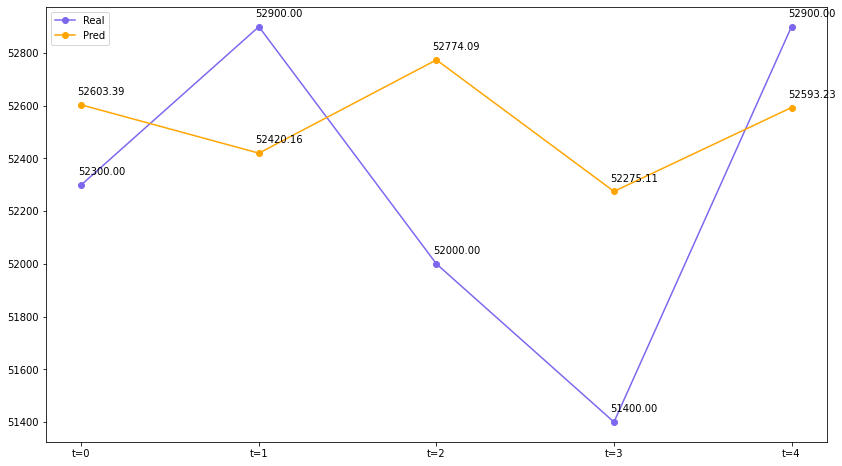

In [78]:
L_node = 128
activation = 'tanh'
optimizer = 'adam'
batch_size = 8
D_node = 64
dropout = .15
epochs = 100

true_price, pred_price = model_2_flow(df_mat, trainX, trainY, validX, validY, testX, testY, 
                                      L_node, 
                                      activation, 
                                      optimizer, 
                                      batch_size, 
                                      D_node, 
                                      dropout, 
                                      epochs)